In [1]:
import pandas as pd
import numpy as np 
import pandas_profiling as pp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import auc , roc_curve, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.simplefilter('ignore')

import matplotlib.style as stl 
stl.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (25, 25)

In [2]:
train = pd.read_csv('../data/modulbank_train.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/modulbank_test.csv', sep='\t', index_col=0 )

In [3]:
const_columns = ['9', '140', '164'] 
const_in_test_1 = ['11']
const_in_test = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
zero_train_features = ['152', '160']


def preprocess(train_df, test_df):
    train = train_df.drop(const_columns, axis=1)
    test = test_df.drop(const_columns, axis=1)
    
    for column in const_in_test:
        train = train[train[column] == 0].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    for column in const_in_test_1:
        train = train[train[column] == 1].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    X_train = train.drop('0', axis=1).reset_index(drop=True)
    y_train = train['0'].reset_index(drop=True)
    X_test = test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

xtrain, ytrain, xtest = preprocess(train, test)

In [4]:
skf = StratifiedKFold(n_splits=8, random_state=42)

In [5]:
def to_submission(predictions, filename):
    seria = pd.Series(predictions, name='_VAL_')
    seria.to_csv(filename, header=True, index_label='_ID_')

###  Постройте XGBoost. Укажите значение на валидации и публичном лидерборде *

In [6]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(xtrain, ytrain, feature_names=xtrain.columns)

nrounds = 10000
results = xgb.cv(params_xgb, xgb_train, num_boost_round=nrounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)

[0]	train-auc:0.71268+0.00692719	test-auc:0.673044+0.0070593
[1]	train-auc:0.738419+0.00542424	test-auc:0.695339+0.00428672
[2]	train-auc:0.744912+0.00536753	test-auc:0.698944+0.00448138
[3]	train-auc:0.748717+0.00533202	test-auc:0.701979+0.00507496
[4]	train-auc:0.756143+0.00430288	test-auc:0.705472+0.00473825
[5]	train-auc:0.75795+0.0045295	test-auc:0.707209+0.00602391
[6]	train-auc:0.759782+0.00390986	test-auc:0.708094+0.00447251
[7]	train-auc:0.76043+0.0040129	test-auc:0.709588+0.00436313
[8]	train-auc:0.761076+0.00468144	test-auc:0.709389+0.00575544
[9]	train-auc:0.763891+0.00482866	test-auc:0.711285+0.00547552
[10]	train-auc:0.765016+0.00493865	test-auc:0.711129+0.00458951
[11]	train-auc:0.765224+0.00531576	test-auc:0.711307+0.0050091
[12]	train-auc:0.765641+0.0051413	test-auc:0.711953+0.00505108
[13]	train-auc:0.766271+0.00503503	test-auc:0.712725+0.00491208
[14]	train-auc:0.766778+0.00511312	test-auc:0.713319+0.0051946
[15]	train-auc:0.767369+0.00550408	test-auc:0.713038+0.0051

[129]	train-auc:0.812587+0.00370131	test-auc:0.726608+0.00507963
[130]	train-auc:0.81284+0.00366159	test-auc:0.726729+0.00512541
[131]	train-auc:0.813089+0.00370359	test-auc:0.72682+0.00515932
[132]	train-auc:0.813628+0.00362075	test-auc:0.726905+0.00510355
[133]	train-auc:0.813934+0.0035996	test-auc:0.727107+0.00505809
[134]	train-auc:0.81435+0.00373038	test-auc:0.727292+0.00507371
[135]	train-auc:0.814582+0.003795	test-auc:0.727384+0.00495703
[136]	train-auc:0.814868+0.00382906	test-auc:0.727397+0.00495193
[137]	train-auc:0.815122+0.0038707	test-auc:0.727494+0.00493335
[138]	train-auc:0.815546+0.00376083	test-auc:0.727582+0.00487829
[139]	train-auc:0.815751+0.00383609	test-auc:0.727695+0.00486137
[140]	train-auc:0.816303+0.00380131	test-auc:0.727854+0.00493829
[141]	train-auc:0.816709+0.0038954	test-auc:0.727894+0.00488677
[142]	train-auc:0.817075+0.00367634	test-auc:0.727968+0.00486111
[143]	train-auc:0.817449+0.00359855	test-auc:0.728031+0.00485556
[144]	train-auc:0.817779+0.003596

[256]	train-auc:0.855825+0.00176999	test-auc:0.735313+0.00522622
[257]	train-auc:0.856122+0.00179699	test-auc:0.735354+0.00521685
[258]	train-auc:0.856422+0.0018259	test-auc:0.735461+0.00516223
[259]	train-auc:0.856753+0.00178834	test-auc:0.735512+0.0051788
[260]	train-auc:0.857073+0.0017444	test-auc:0.73558+0.00516703
[261]	train-auc:0.857451+0.00169074	test-auc:0.735674+0.00514594
[262]	train-auc:0.857729+0.00170086	test-auc:0.735754+0.00516955
[263]	train-auc:0.85806+0.00168686	test-auc:0.735835+0.00520961
[264]	train-auc:0.858362+0.00167699	test-auc:0.735838+0.0052272
[265]	train-auc:0.858708+0.00159744	test-auc:0.735838+0.0052509
[266]	train-auc:0.859028+0.00161182	test-auc:0.735871+0.00525873
[267]	train-auc:0.859365+0.00159376	test-auc:0.735888+0.00526647
[268]	train-auc:0.859625+0.00160654	test-auc:0.735929+0.0053114
[269]	train-auc:0.859976+0.00160121	test-auc:0.735955+0.0052766
[270]	train-auc:0.860299+0.00160752	test-auc:0.736013+0.00527702
[271]	train-auc:0.860546+0.0016383

[383]	train-auc:0.889177+0.00154845	test-auc:0.739604+0.00541945
[384]	train-auc:0.889447+0.00160266	test-auc:0.739654+0.00540407
[385]	train-auc:0.889648+0.00156689	test-auc:0.739705+0.00539012
[386]	train-auc:0.889905+0.00154951	test-auc:0.739701+0.00538013
[387]	train-auc:0.890126+0.0015642	test-auc:0.739718+0.00543244
[388]	train-auc:0.890289+0.00157066	test-auc:0.73974+0.0054294
[389]	train-auc:0.890496+0.00156693	test-auc:0.739776+0.00545696
[390]	train-auc:0.890759+0.00150562	test-auc:0.739766+0.00543998
[391]	train-auc:0.890946+0.00147111	test-auc:0.739763+0.00545946
[392]	train-auc:0.891138+0.00148856	test-auc:0.739768+0.00548681
[393]	train-auc:0.891345+0.00152023	test-auc:0.739724+0.00544285
[394]	train-auc:0.891558+0.00146922	test-auc:0.739725+0.00547636
[395]	train-auc:0.891742+0.00140396	test-auc:0.739724+0.00549109
[396]	train-auc:0.891956+0.00140751	test-auc:0.739742+0.00549319
[397]	train-auc:0.892197+0.00136139	test-auc:0.739779+0.00550873
[398]	train-auc:0.892423+0.0

[510]	train-auc:0.913671+0.00143403	test-auc:0.741454+0.00618881
[511]	train-auc:0.913761+0.00142916	test-auc:0.741465+0.00618373
[512]	train-auc:0.913998+0.00139058	test-auc:0.741475+0.00614969
[513]	train-auc:0.914125+0.00139792	test-auc:0.741461+0.00616812
[514]	train-auc:0.914263+0.00136091	test-auc:0.741443+0.00615552
[515]	train-auc:0.914494+0.00135107	test-auc:0.74147+0.00616084
[516]	train-auc:0.914696+0.00131947	test-auc:0.741453+0.00618806
[517]	train-auc:0.914833+0.00130026	test-auc:0.741462+0.00622431
[518]	train-auc:0.914959+0.00128645	test-auc:0.741466+0.00626789
[519]	train-auc:0.915154+0.00123088	test-auc:0.74149+0.00625865
[520]	train-auc:0.9153+0.00122423	test-auc:0.741503+0.00626896
[521]	train-auc:0.915433+0.00126103	test-auc:0.741531+0.0062613
[522]	train-auc:0.915596+0.00119445	test-auc:0.741541+0.00630491
[523]	train-auc:0.91574+0.0012134	test-auc:0.741529+0.00628016
[524]	train-auc:0.915907+0.00124216	test-auc:0.741559+0.0062481
[525]	train-auc:0.916027+0.001233

[637]	train-auc:0.931299+0.00113579	test-auc:0.742089+0.00662993
[638]	train-auc:0.931396+0.00113733	test-auc:0.742076+0.00663836
[639]	train-auc:0.931526+0.00111498	test-auc:0.742041+0.00665012
[640]	train-auc:0.931662+0.00113999	test-auc:0.742089+0.0066652
[641]	train-auc:0.931796+0.00108514	test-auc:0.74209+0.00665644
[642]	train-auc:0.931949+0.00107608	test-auc:0.742126+0.0066498
[643]	train-auc:0.932119+0.0010924	test-auc:0.742102+0.00662439
[644]	train-auc:0.932243+0.00115268	test-auc:0.742099+0.00662549
[645]	train-auc:0.932301+0.00117396	test-auc:0.742108+0.00665619
[646]	train-auc:0.932428+0.00115889	test-auc:0.742118+0.00663651
[647]	train-auc:0.932565+0.00121312	test-auc:0.742118+0.00663543
[648]	train-auc:0.932697+0.00115809	test-auc:0.742129+0.0066277
[649]	train-auc:0.932879+0.00115971	test-auc:0.742163+0.00661036
[650]	train-auc:0.933052+0.00115569	test-auc:0.742216+0.00662213
[651]	train-auc:0.933191+0.00122604	test-auc:0.742232+0.00664578
[652]	train-auc:0.933263+0.001

[764]	train-auc:0.945661+0.00102476	test-auc:0.742322+0.0069018
[765]	train-auc:0.945759+0.00105394	test-auc:0.742309+0.00689194
[766]	train-auc:0.945863+0.00105211	test-auc:0.742309+0.00688685
[767]	train-auc:0.945977+0.0011045	test-auc:0.742323+0.00690085
[768]	train-auc:0.946076+0.00108147	test-auc:0.742328+0.00689454
[769]	train-auc:0.946159+0.0010634	test-auc:0.742351+0.00690298
[770]	train-auc:0.94626+0.0010573	test-auc:0.742384+0.00689729
[771]	train-auc:0.946351+0.00108108	test-auc:0.742372+0.00692079
[772]	train-auc:0.946443+0.00104327	test-auc:0.742381+0.00693791
[773]	train-auc:0.946538+0.00102723	test-auc:0.742361+0.00691981
[774]	train-auc:0.946628+0.00104643	test-auc:0.742356+0.00696105
[775]	train-auc:0.946771+0.00101442	test-auc:0.742355+0.00696187
[776]	train-auc:0.946876+0.00103913	test-auc:0.742344+0.00697219
[777]	train-auc:0.94699+0.00104173	test-auc:0.742331+0.0069924
[778]	train-auc:0.947077+0.00104914	test-auc:0.742333+0.00699273
[779]	train-auc:0.947131+0.00106

[891]	train-auc:0.956819+0.00113155	test-auc:0.742365+0.00694918
[892]	train-auc:0.95689+0.00113899	test-auc:0.742329+0.00694557
[893]	train-auc:0.956983+0.00114704	test-auc:0.742317+0.00695152
[894]	train-auc:0.957077+0.00112762	test-auc:0.742312+0.00694395
[895]	train-auc:0.957187+0.00112545	test-auc:0.742266+0.00695036
[896]	train-auc:0.957278+0.00113626	test-auc:0.742262+0.00697444
[897]	train-auc:0.95734+0.00114756	test-auc:0.742243+0.00697399
[898]	train-auc:0.957427+0.00114485	test-auc:0.742229+0.00697233
[899]	train-auc:0.957528+0.00113834	test-auc:0.742242+0.00696411
[900]	train-auc:0.957603+0.00112291	test-auc:0.742263+0.00698547
[901]	train-auc:0.957685+0.00113859	test-auc:0.742266+0.00698671
[902]	train-auc:0.957757+0.00113322	test-auc:0.742281+0.00699989
[903]	train-auc:0.957832+0.00113923	test-auc:0.742252+0.0069857
[904]	train-auc:0.957913+0.0011343	test-auc:0.742274+0.00700566
[905]	train-auc:0.957977+0.0011277	test-auc:0.742279+0.00698688
[906]	train-auc:0.958048+0.001

In [11]:
results['test-auc-mean'].iloc[-1]   # LB 0.7641

0.7424143333333334

In [12]:
xgb_test= xgb.DMatrix(xtest)
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
xgb_predictions = xgb_model.predict(xgb_test)

In [14]:
xgb_predictions_cv = []
for train_idx, val in skf.split(xtrain, ytrain):
    xgb_train = xgb.DMatrix(xtrain.iloc[train_idx], ytrain.iloc[train_idx])
    xgb_test= xgb.DMatrix(xtrain.iloc[val])
    
    xgb_model = xgb.train(params_xgb, xgb_train, len(results))
    xgb_predictions_ = xgb_model.predict(xgb_test)

    xgb_predictions_cv.append([ytrain.iloc[val], xgb_predictions_])

###  Постройте LightGBM. Укажите значение на валидации и публичном лидерборде *

In [15]:
params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 8, 
    'num_leaves': 128, 
    'min_data_in_leaf' : 17
    
    }

n_rounds = 10000
lgb_train = lgb.Dataset(xtrain, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(xtrain, ytrain), 
                early_stopping_rounds=50, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.676039 + 0.0104639
[2]	cv_agg's auc: 0.694946 + 0.00773686
[3]	cv_agg's auc: 0.705338 + 0.00831292
[4]	cv_agg's auc: 0.710346 + 0.00742703
[5]	cv_agg's auc: 0.713366 + 0.00671345
[6]	cv_agg's auc: 0.71552 + 0.00775324
[7]	cv_agg's auc: 0.716476 + 0.00840844
[8]	cv_agg's auc: 0.717386 + 0.00777885
[9]	cv_agg's auc: 0.718749 + 0.00699781
[10]	cv_agg's auc: 0.71961 + 0.00685962
[11]	cv_agg's auc: 0.719811 + 0.00677607
[12]	cv_agg's auc: 0.720337 + 0.00674986
[13]	cv_agg's auc: 0.721143 + 0.00671426
[14]	cv_agg's auc: 0.721573 + 0.0066056
[15]	cv_agg's auc: 0.72175 + 0.00646456
[16]	cv_agg's auc: 0.721847 + 0.00641165
[17]	cv_agg's auc: 0.723002 + 0.00610389
[18]	cv_agg's auc: 0.723383 + 0.0060247
[19]	cv_agg's auc: 0.723318 + 0.00606046
[20]	cv_agg's auc: 0.723313 + 0.00613975
[21]	cv_agg's auc: 0.723707 + 0.00578125
[22]	cv_agg's auc: 0.723695 + 0.00563119
[23]	cv_agg's auc: 0.724146 + 0.00549531
[24]	cv_agg's auc: 0.724572 + 0.00497012
[25]	cv_agg's auc: 0.724937 + 0

[200]	cv_agg's auc: 0.738876 + 0.00595498
[201]	cv_agg's auc: 0.738921 + 0.00601916
[202]	cv_agg's auc: 0.738966 + 0.00603214
[203]	cv_agg's auc: 0.739016 + 0.0060466
[204]	cv_agg's auc: 0.739014 + 0.00603429
[205]	cv_agg's auc: 0.738998 + 0.00606744
[206]	cv_agg's auc: 0.739071 + 0.0061177
[207]	cv_agg's auc: 0.739138 + 0.00608234
[208]	cv_agg's auc: 0.739158 + 0.00607288
[209]	cv_agg's auc: 0.739182 + 0.00607109
[210]	cv_agg's auc: 0.739295 + 0.00612821
[211]	cv_agg's auc: 0.739359 + 0.00612265
[212]	cv_agg's auc: 0.739409 + 0.00611685
[213]	cv_agg's auc: 0.739429 + 0.00617582
[214]	cv_agg's auc: 0.739417 + 0.00614863
[215]	cv_agg's auc: 0.739464 + 0.00619034
[216]	cv_agg's auc: 0.739498 + 0.00624661
[217]	cv_agg's auc: 0.739543 + 0.00626355
[218]	cv_agg's auc: 0.739508 + 0.00627431
[219]	cv_agg's auc: 0.73955 + 0.00626743
[220]	cv_agg's auc: 0.739612 + 0.00634098
[221]	cv_agg's auc: 0.739673 + 0.0063826
[222]	cv_agg's auc: 0.739729 + 0.00641141
[223]	cv_agg's auc: 0.739789 + 0.00642

[397]	cv_agg's auc: 0.745328 + 0.0075149
[398]	cv_agg's auc: 0.74533 + 0.00750897
[399]	cv_agg's auc: 0.745314 + 0.00752287
[400]	cv_agg's auc: 0.74533 + 0.00752864
[401]	cv_agg's auc: 0.74538 + 0.00754144
[402]	cv_agg's auc: 0.745378 + 0.00753749
[403]	cv_agg's auc: 0.745389 + 0.00754878
[404]	cv_agg's auc: 0.745449 + 0.00757599
[405]	cv_agg's auc: 0.74543 + 0.00758765
[406]	cv_agg's auc: 0.745475 + 0.00755889
[407]	cv_agg's auc: 0.745498 + 0.00756263
[408]	cv_agg's auc: 0.745537 + 0.00755457
[409]	cv_agg's auc: 0.745573 + 0.00758733
[410]	cv_agg's auc: 0.745572 + 0.00761961
[411]	cv_agg's auc: 0.745606 + 0.00761729
[412]	cv_agg's auc: 0.745639 + 0.00760605
[413]	cv_agg's auc: 0.745686 + 0.00760418
[414]	cv_agg's auc: 0.745652 + 0.00761846
[415]	cv_agg's auc: 0.745676 + 0.0076219
[416]	cv_agg's auc: 0.745685 + 0.00763912
[417]	cv_agg's auc: 0.745711 + 0.00763961
[418]	cv_agg's auc: 0.745694 + 0.007633
[419]	cv_agg's auc: 0.745685 + 0.00765118
[420]	cv_agg's auc: 0.74571 + 0.00765074
[

[594]	cv_agg's auc: 0.747267 + 0.00828956
[595]	cv_agg's auc: 0.7473 + 0.00829992
[596]	cv_agg's auc: 0.747293 + 0.00833306
[597]	cv_agg's auc: 0.7473 + 0.00832399
[598]	cv_agg's auc: 0.747315 + 0.00831059
[599]	cv_agg's auc: 0.74732 + 0.00830203
[600]	cv_agg's auc: 0.747334 + 0.00831756
[601]	cv_agg's auc: 0.747322 + 0.00833457
[602]	cv_agg's auc: 0.747364 + 0.00831519
[603]	cv_agg's auc: 0.747376 + 0.00834227
[604]	cv_agg's auc: 0.747411 + 0.00835644
[605]	cv_agg's auc: 0.747404 + 0.00836722
[606]	cv_agg's auc: 0.747411 + 0.00836327
[607]	cv_agg's auc: 0.747444 + 0.00836831
[608]	cv_agg's auc: 0.747433 + 0.00836381
[609]	cv_agg's auc: 0.74744 + 0.0083978
[610]	cv_agg's auc: 0.747456 + 0.00841458
[611]	cv_agg's auc: 0.747444 + 0.00842551
[612]	cv_agg's auc: 0.747453 + 0.00840631
[613]	cv_agg's auc: 0.747457 + 0.00840171
[614]	cv_agg's auc: 0.747491 + 0.00841623
[615]	cv_agg's auc: 0.747493 + 0.00840128
[616]	cv_agg's auc: 0.747467 + 0.00841059
[617]	cv_agg's auc: 0.747484 + 0.00841133

[791]	cv_agg's auc: 0.747859 + 0.00880552
[792]	cv_agg's auc: 0.747836 + 0.00883572
[793]	cv_agg's auc: 0.747843 + 0.00882523
[794]	cv_agg's auc: 0.747848 + 0.00881167
[795]	cv_agg's auc: 0.747836 + 0.00881616
[796]	cv_agg's auc: 0.747845 + 0.00881933
[797]	cv_agg's auc: 0.747856 + 0.00884622
[798]	cv_agg's auc: 0.747843 + 0.00882519
[799]	cv_agg's auc: 0.747845 + 0.00879919
[800]	cv_agg's auc: 0.747865 + 0.00881475
[801]	cv_agg's auc: 0.747875 + 0.00882126
[802]	cv_agg's auc: 0.747895 + 0.00885277
[803]	cv_agg's auc: 0.747894 + 0.00887849
[804]	cv_agg's auc: 0.747901 + 0.0088754
[805]	cv_agg's auc: 0.747875 + 0.00886223
[806]	cv_agg's auc: 0.74788 + 0.00890531
[807]	cv_agg's auc: 0.747878 + 0.00890443
[808]	cv_agg's auc: 0.747859 + 0.00891378
[809]	cv_agg's auc: 0.747869 + 0.00889347
[810]	cv_agg's auc: 0.747855 + 0.0088992
[811]	cv_agg's auc: 0.747865 + 0.00888271
[812]	cv_agg's auc: 0.747875 + 0.0089186
[813]	cv_agg's auc: 0.74786 + 0.00893413
[814]	cv_agg's auc: 0.747848 + 0.008919

0.7479643146488338

In [16]:
lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))

lgb_predictions = lgb_model.predict(xtest)

#LB 0.76363613

In [17]:
lgb_predictions_cv = []

for train_idx, val in skf.split(xtrain, ytrain):
    
    lgb_train = lgb.Dataset(xtrain.iloc[train_idx], label=ytrain.iloc[train_idx],  free_raw_data=False)
    lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))
    lgb_predictions_= lgb_model.predict(xtrain.iloc[val])
    
    lgb_predictions_cv.append([ytrain.iloc[val], lgb_predictions_])

### Постройте CatBoost. Укажите значение на валидации и публичном лидерборде *

In [26]:
#categorical_features_indices = np.where(xtrain.dtypes != np.float)[0]
params_ctb = {
    
    'eval_metric': 'AUC',
    'iterations': 10000,
    'learning_rate': 0.03,
    'random_seed': 42,
    'od_wait': 100,
    'od_type': 'Iter',
    'thread_count':4,
    
    
    #regularization
    'depth':  10
}

ctb_train = ctb.Pool(xtrain,ytrain) #cat_features=categorical_features_indices,
results_ctb = ctb.cv(ctb_train, params_ctb,  stratified=True,  logging_level='Verbose')

0:	learn: 0.6687488	test: 0.6581647	best: 0.6581647 (0)	total: 1.22s	remaining: 3h 23m 44s
1:	learn: 0.6954838	test: 0.6818254	best: 0.6818254 (1)	total: 2.36s	remaining: 3h 16m 55s
2:	learn: 0.6991400	test: 0.6843752	best: 0.6843752 (2)	total: 3.48s	remaining: 3h 13m 17s
3:	learn: 0.7054530	test: 0.6909408	best: 0.6909408 (3)	total: 4.76s	remaining: 3h 18m 26s
4:	learn: 0.7099471	test: 0.6931616	best: 0.6931616 (4)	total: 6.22s	remaining: 3h 27m 22s
5:	learn: 0.7099973	test: 0.6935735	best: 0.6935735 (5)	total: 7.41s	remaining: 3h 25m 35s
6:	learn: 0.7098190	test: 0.6927899	best: 0.6935735 (5)	total: 9.01s	remaining: 3h 34m 25s
7:	learn: 0.7108056	test: 0.6938674	best: 0.6938674 (7)	total: 10.3s	remaining: 3h 35m 19s
8:	learn: 0.7117343	test: 0.6943259	best: 0.6943259 (8)	total: 11.8s	remaining: 3h 39m 4s
9:	learn: 0.7127124	test: 0.6951304	best: 0.6951304 (9)	total: 13.1s	remaining: 3h 38m 46s
10:	learn: 0.7120786	test: 0.6950695	best: 0.6951304 (9)	total: 14.2s	remaining: 3h 34m 33s

89:	learn: 0.7558493	test: 0.7221283	best: 0.7221283 (89)	total: 1m 54s	remaining: 3h 30m
90:	learn: 0.7564421	test: 0.7224294	best: 0.7224294 (90)	total: 1m 55s	remaining: 3h 30m 7s
91:	learn: 0.7567895	test: 0.7226184	best: 0.7226184 (91)	total: 1m 57s	remaining: 3h 30m 3s
92:	learn: 0.7574315	test: 0.7227534	best: 0.7227534 (92)	total: 1m 58s	remaining: 3h 30m 6s
93:	learn: 0.7577965	test: 0.7228410	best: 0.7228410 (93)	total: 1m 59s	remaining: 3h 30m 7s
94:	learn: 0.7583534	test: 0.7230293	best: 0.7230293 (94)	total: 2m	remaining: 3h 30m 4s
95:	learn: 0.7589398	test: 0.7232303	best: 0.7232303 (95)	total: 2m 2s	remaining: 3h 30m 3s
96:	learn: 0.7594341	test: 0.7233973	best: 0.7233973 (96)	total: 2m 3s	remaining: 3h 29m 54s
97:	learn: 0.7597529	test: 0.7235013	best: 0.7235013 (97)	total: 2m 4s	remaining: 3h 29m 26s
98:	learn: 0.7600215	test: 0.7236886	best: 0.7236886 (98)	total: 2m 5s	remaining: 3h 29m 31s
99:	learn: 0.7604335	test: 0.7237866	best: 0.7237866 (99)	total: 2m 6s	remaini

176:	learn: 0.7923164	test: 0.7323200	best: 0.7323200 (176)	total: 3m 48s	remaining: 3h 31m 22s
177:	learn: 0.7927834	test: 0.7324925	best: 0.7324925 (177)	total: 3m 49s	remaining: 3h 31m 17s
178:	learn: 0.7932955	test: 0.7325124	best: 0.7325124 (178)	total: 3m 50s	remaining: 3h 31m 4s
179:	learn: 0.7936709	test: 0.7325626	best: 0.7325626 (179)	total: 3m 52s	remaining: 3h 31m 5s
180:	learn: 0.7940033	test: 0.7326367	best: 0.7326367 (180)	total: 3m 53s	remaining: 3h 31m 15s
181:	learn: 0.7943695	test: 0.7327376	best: 0.7327376 (181)	total: 3m 55s	remaining: 3h 31m 41s
182:	learn: 0.7947815	test: 0.7328611	best: 0.7328611 (182)	total: 3m 57s	remaining: 3h 32m 5s
183:	learn: 0.7950288	test: 0.7329900	best: 0.7329900 (183)	total: 3m 59s	remaining: 3h 32m 30s
184:	learn: 0.7954608	test: 0.7331310	best: 0.7331310 (184)	total: 4m	remaining: 3h 32m 43s
185:	learn: 0.7958868	test: 0.7331948	best: 0.7331948 (185)	total: 4m 2s	remaining: 3h 32m 55s
186:	learn: 0.7961938	test: 0.7333538	best: 0.73

262:	learn: 0.8197888	test: 0.7369340	best: 0.7369449 (261)	total: 6m 5s	remaining: 3h 45m 31s
263:	learn: 0.8202322	test: 0.7370193	best: 0.7370193 (263)	total: 6m 6s	remaining: 3h 45m 24s
264:	learn: 0.8204791	test: 0.7370920	best: 0.7370920 (264)	total: 6m 8s	remaining: 3h 45m 22s
265:	learn: 0.8206279	test: 0.7371548	best: 0.7371548 (265)	total: 6m 9s	remaining: 3h 45m 13s
266:	learn: 0.8208728	test: 0.7371613	best: 0.7371613 (266)	total: 6m 10s	remaining: 3h 45m 12s
267:	learn: 0.8211251	test: 0.7371507	best: 0.7371613 (266)	total: 6m 12s	remaining: 3h 45m 9s
268:	learn: 0.8212932	test: 0.7372271	best: 0.7372271 (268)	total: 6m 13s	remaining: 3h 45m 4s
269:	learn: 0.8216104	test: 0.7373071	best: 0.7373071 (269)	total: 6m 14s	remaining: 3h 45m 1s
270:	learn: 0.8218462	test: 0.7373505	best: 0.7373505 (270)	total: 6m 16s	remaining: 3h 45m 20s
271:	learn: 0.8221147	test: 0.7373965	best: 0.7373965 (271)	total: 6m 18s	remaining: 3h 45m 47s
272:	learn: 0.8224197	test: 0.7374693	best: 0.7

348:	learn: 0.8461523	test: 0.7395503	best: 0.7395926 (346)	total: 8m 23s	remaining: 3h 52m 6s
349:	learn: 0.8466224	test: 0.7395299	best: 0.7395926 (346)	total: 8m 25s	remaining: 3h 52m 4s
350:	learn: 0.8469575	test: 0.7395648	best: 0.7395926 (346)	total: 8m 26s	remaining: 3h 52m 5s
351:	learn: 0.8473488	test: 0.7395974	best: 0.7395974 (351)	total: 8m 28s	remaining: 3h 52m 5s
352:	learn: 0.8477306	test: 0.7396167	best: 0.7396167 (352)	total: 8m 29s	remaining: 3h 52m 9s
353:	learn: 0.8481908	test: 0.7396453	best: 0.7396453 (353)	total: 8m 31s	remaining: 3h 52m 19s
354:	learn: 0.8485507	test: 0.7396752	best: 0.7396752 (354)	total: 8m 33s	remaining: 3h 52m 32s
355:	learn: 0.8488324	test: 0.7397784	best: 0.7397784 (355)	total: 8m 35s	remaining: 3h 52m 44s
356:	learn: 0.8491466	test: 0.7397913	best: 0.7397913 (356)	total: 8m 37s	remaining: 3h 52m 45s
357:	learn: 0.8493781	test: 0.7398441	best: 0.7398441 (357)	total: 8m 38s	remaining: 3h 52m 49s
358:	learn: 0.8497222	test: 0.7398000	best: 0

434:	learn: 0.8757800	test: 0.7402349	best: 0.7404280 (420)	total: 10m 39s	remaining: 3h 54m 14s
435:	learn: 0.8760298	test: 0.7402214	best: 0.7404280 (420)	total: 10m 40s	remaining: 3h 54m 8s
436:	learn: 0.8762984	test: 0.7402859	best: 0.7404280 (420)	total: 10m 41s	remaining: 3h 54m 1s
437:	learn: 0.8767428	test: 0.7403208	best: 0.7404280 (420)	total: 10m 42s	remaining: 3h 53m 56s
438:	learn: 0.8770196	test: 0.7402765	best: 0.7404280 (420)	total: 10m 44s	remaining: 3h 53m 51s
439:	learn: 0.8773066	test: 0.7403063	best: 0.7404280 (420)	total: 10m 45s	remaining: 3h 53m 45s
440:	learn: 0.8776184	test: 0.7403262	best: 0.7404280 (420)	total: 10m 46s	remaining: 3h 53m 38s
441:	learn: 0.8779785	test: 0.7403507	best: 0.7404280 (420)	total: 10m 47s	remaining: 3h 53m 31s
442:	learn: 0.8783022	test: 0.7403929	best: 0.7404280 (420)	total: 10m 49s	remaining: 3h 53m 25s
443:	learn: 0.8785947	test: 0.7404022	best: 0.7404280 (420)	total: 10m 50s	remaining: 3h 53m 21s
444:	learn: 0.8789104	test: 0.74

519:	learn: 0.8992112	test: 0.7407514	best: 0.7409462 (499)	total: 12m 33s	remaining: 3h 48m 52s
520:	learn: 0.8993896	test: 0.7407087	best: 0.7409462 (499)	total: 12m 34s	remaining: 3h 48m 46s
521:	learn: 0.8996368	test: 0.7406952	best: 0.7409462 (499)	total: 12m 35s	remaining: 3h 48m 40s
522:	learn: 0.8998655	test: 0.7406933	best: 0.7409462 (499)	total: 12m 36s	remaining: 3h 48m 35s
523:	learn: 0.9000588	test: 0.7406900	best: 0.7409462 (499)	total: 12m 38s	remaining: 3h 48m 31s
524:	learn: 0.9003790	test: 0.7407180	best: 0.7409462 (499)	total: 12m 39s	remaining: 3h 48m 25s
525:	learn: 0.9006341	test: 0.7407225	best: 0.7409462 (499)	total: 12m 40s	remaining: 3h 48m 19s
526:	learn: 0.9009717	test: 0.7407357	best: 0.7409462 (499)	total: 12m 41s	remaining: 3h 48m 15s
527:	learn: 0.9011899	test: 0.7406955	best: 0.7409462 (499)	total: 12m 43s	remaining: 3h 48m 12s
528:	learn: 0.9013704	test: 0.7407096	best: 0.7409462 (499)	total: 12m 44s	remaining: 3h 48m 11s
529:	learn: 0.9015227	test: 0.

604:	learn: 0.9164408	test: 0.7404178	best: 0.7411053 (557)	total: 14m 29s	remaining: 3h 45m 7s
605:	learn: 0.9166900	test: 0.7404058	best: 0.7411053 (557)	total: 14m 31s	remaining: 3h 45m 5s
606:	learn: 0.9169375	test: 0.7403396	best: 0.7411053 (557)	total: 14m 32s	remaining: 3h 45m 2s
607:	learn: 0.9171450	test: 0.7403292	best: 0.7411053 (557)	total: 14m 33s	remaining: 3h 44m 58s
608:	learn: 0.9173050	test: 0.7402916	best: 0.7411053 (557)	total: 14m 35s	remaining: 3h 44m 54s
609:	learn: 0.9174665	test: 0.7402641	best: 0.7411053 (557)	total: 14m 36s	remaining: 3h 44m 50s
610:	learn: 0.9176540	test: 0.7402182	best: 0.7411053 (557)	total: 14m 37s	remaining: 3h 44m 47s
611:	learn: 0.9178514	test: 0.7402454	best: 0.7411053 (557)	total: 14m 39s	remaining: 3h 44m 45s
612:	learn: 0.9180433	test: 0.7402267	best: 0.7411053 (557)	total: 14m 40s	remaining: 3h 44m 43s
613:	learn: 0.9181331	test: 0.7402244	best: 0.7411053 (557)	total: 14m 41s	remaining: 3h 44m 41s
614:	learn: 0.9182570	test: 0.740

In [27]:
ctb_train = ctb.Pool(xtrain,ytrain)
ctb_model = ctb.train(ctb_train, params_ctb, logging_level='Verbose',num_boost_round=557)
ctb_predictions = ctb_model.predict(ctb.Pool(xtest))

0:	learn: 0.6547314	total: 743ms	remaining: 6m 53s
1:	learn: 0.6752016	total: 1.33s	remaining: 6m 8s
2:	learn: 0.6895981	total: 1.91s	remaining: 5m 52s
3:	learn: 0.6958836	total: 2.48s	remaining: 5m 42s
4:	learn: 0.7043721	total: 2.97s	remaining: 5m 27s
5:	learn: 0.7040582	total: 3.5s	remaining: 5m 21s
6:	learn: 0.7082559	total: 3.93s	remaining: 5m 9s
7:	learn: 0.7106538	total: 4.44s	remaining: 5m 4s
8:	learn: 0.7129852	total: 4.88s	remaining: 4m 57s
9:	learn: 0.7160687	total: 5.37s	remaining: 4m 53s
10:	learn: 0.7146183	total: 5.8s	remaining: 4m 48s
11:	learn: 0.7130388	total: 6.27s	remaining: 4m 44s
12:	learn: 0.7136053	total: 6.77s	remaining: 4m 43s
13:	learn: 0.7158304	total: 7.29s	remaining: 4m 42s
14:	learn: 0.7165480	total: 7.77s	remaining: 4m 40s
15:	learn: 0.7166322	total: 8.29s	remaining: 4m 40s
16:	learn: 0.7176396	total: 8.78s	remaining: 4m 38s
17:	learn: 0.7167904	total: 9.31s	remaining: 4m 38s
18:	learn: 0.7176538	total: 9.81s	remaining: 4m 37s
19:	learn: 0.7179242	total:

158:	learn: 0.7714930	total: 1m 32s	remaining: 3m 51s
159:	learn: 0.7718601	total: 1m 33s	remaining: 3m 52s
160:	learn: 0.7719625	total: 1m 33s	remaining: 3m 50s
161:	learn: 0.7723023	total: 1m 34s	remaining: 3m 50s
162:	learn: 0.7727713	total: 1m 35s	remaining: 3m 50s
163:	learn: 0.7731496	total: 1m 35s	remaining: 3m 49s
164:	learn: 0.7734961	total: 1m 36s	remaining: 3m 48s
165:	learn: 0.7737804	total: 1m 36s	remaining: 3m 48s
166:	learn: 0.7744905	total: 1m 37s	remaining: 3m 47s
167:	learn: 0.7753953	total: 1m 38s	remaining: 3m 47s
168:	learn: 0.7760671	total: 1m 38s	remaining: 3m 46s
169:	learn: 0.7763589	total: 1m 39s	remaining: 3m 46s
170:	learn: 0.7764661	total: 1m 40s	remaining: 3m 45s
171:	learn: 0.7766669	total: 1m 40s	remaining: 3m 45s
172:	learn: 0.7770298	total: 1m 41s	remaining: 3m 44s
173:	learn: 0.7774259	total: 1m 42s	remaining: 3m 44s
174:	learn: 0.7774724	total: 1m 42s	remaining: 3m 43s
175:	learn: 0.7778127	total: 1m 43s	remaining: 3m 43s
176:	learn: 0.7780998	total:

311:	learn: 0.8100279	total: 3m 6s	remaining: 2m 26s
312:	learn: 0.8102371	total: 3m 7s	remaining: 2m 26s
313:	learn: 0.8105490	total: 3m 8s	remaining: 2m 25s
314:	learn: 0.8108571	total: 3m 8s	remaining: 2m 25s
315:	learn: 0.8110728	total: 3m 9s	remaining: 2m 24s
316:	learn: 0.8115880	total: 3m 10s	remaining: 2m 24s
317:	learn: 0.8119470	total: 3m 11s	remaining: 2m 23s
318:	learn: 0.8124463	total: 3m 12s	remaining: 2m 23s
319:	learn: 0.8127107	total: 3m 12s	remaining: 2m 22s
320:	learn: 0.8129259	total: 3m 13s	remaining: 2m 22s
321:	learn: 0.8130955	total: 3m 14s	remaining: 2m 21s
322:	learn: 0.8133659	total: 3m 15s	remaining: 2m 21s
323:	learn: 0.8135109	total: 3m 15s	remaining: 2m 20s
324:	learn: 0.8137156	total: 3m 16s	remaining: 2m 20s
325:	learn: 0.8138986	total: 3m 16s	remaining: 2m 19s
326:	learn: 0.8141633	total: 3m 17s	remaining: 2m 18s
327:	learn: 0.8144414	total: 3m 18s	remaining: 2m 18s
328:	learn: 0.8146294	total: 3m 19s	remaining: 2m 17s
329:	learn: 0.8148286	total: 3m 1

465:	learn: 0.8545613	total: 4m 45s	remaining: 55.8s
466:	learn: 0.8547529	total: 4m 46s	remaining: 55.2s
467:	learn: 0.8550411	total: 4m 47s	remaining: 54.6s
468:	learn: 0.8552526	total: 4m 47s	remaining: 54s
469:	learn: 0.8555072	total: 4m 48s	remaining: 53.4s
470:	learn: 0.8556797	total: 4m 49s	remaining: 52.8s
471:	learn: 0.8558079	total: 4m 49s	remaining: 52.2s
472:	learn: 0.8561601	total: 4m 50s	remaining: 51.6s
473:	learn: 0.8563922	total: 4m 50s	remaining: 50.9s
474:	learn: 0.8565971	total: 4m 51s	remaining: 50.3s
475:	learn: 0.8567851	total: 4m 51s	remaining: 49.7s
476:	learn: 0.8569832	total: 4m 52s	remaining: 49.1s
477:	learn: 0.8573228	total: 4m 53s	remaining: 48.5s
478:	learn: 0.8576906	total: 4m 53s	remaining: 47.8s
479:	learn: 0.8578957	total: 4m 54s	remaining: 47.2s
480:	learn: 0.8581249	total: 4m 54s	remaining: 46.6s
481:	learn: 0.8584107	total: 4m 55s	remaining: 46s
482:	learn: 0.8586463	total: 4m 56s	remaining: 45.4s
483:	learn: 0.8588049	total: 4m 56s	remaining: 44.

In [ ]:
# skf validation 
for train, val in skf.split(xtrain,ytrain):
    temp_ctb_train = ctb.Pool(xtrain.loc[train], ytrain.loc[train])
    temp_ctb_val = ctb.Pool(xtrain.loc[val], ytrain.loc[val])
    temp_model = ctb.train(temp_ctb_train, params_ctb, logging_level='Verbose', eval_set=temp_ctb_val)

0:	learn: 0.6512785	test: 0.6464585	best: 0.6464585 (0)	total: 588ms	remaining: 1h 37m 58s
1:	learn: 0.6757742	test: 0.6593511	best: 0.6593511 (1)	total: 1.08s	remaining: 1h 29m 47s
2:	learn: 0.6972670	test: 0.6842043	best: 0.6842043 (2)	total: 1.61s	remaining: 1h 29m 33s
3:	learn: 0.6980407	test: 0.6878168	best: 0.6878168 (3)	total: 2.11s	remaining: 1h 27m 47s
4:	learn: 0.7046001	test: 0.6905294	best: 0.6905294 (4)	total: 2.65s	remaining: 1h 28m 24s
5:	learn: 0.7069256	test: 0.6911272	best: 0.6911272 (5)	total: 3.26s	remaining: 1h 30m 37s
6:	learn: 0.7059872	test: 0.6908606	best: 0.6911272 (5)	total: 4.02s	remaining: 1h 35m 40s
7:	learn: 0.7086465	test: 0.6940824	best: 0.6940824 (7)	total: 4.75s	remaining: 1h 38m 54s
8:	learn: 0.7102894	test: 0.6963776	best: 0.6963776 (8)	total: 5.42s	remaining: 1h 40m 14s
9:	learn: 0.7103863	test: 0.6980221	best: 0.6980221 (9)	total: 5.72s	remaining: 1h 35m 12s
10:	learn: 0.7117139	test: 0.7004670	best: 0.7004670 (10)	total: 6.23s	remaining: 1h 34m 1

89:	learn: 0.7494881	test: 0.7229340	best: 0.7229340 (89)	total: 45.8s	remaining: 1h 23m 58s
90:	learn: 0.7498311	test: 0.7229899	best: 0.7229899 (90)	total: 46.3s	remaining: 1h 24m 1s
91:	learn: 0.7501265	test: 0.7233226	best: 0.7233226 (91)	total: 46.8s	remaining: 1h 23m 55s
92:	learn: 0.7504972	test: 0.7235974	best: 0.7235974 (92)	total: 47.3s	remaining: 1h 23m 57s
93:	learn: 0.7509385	test: 0.7236978	best: 0.7236978 (93)	total: 47.8s	remaining: 1h 23m 58s
94:	learn: 0.7512383	test: 0.7237199	best: 0.7237199 (94)	total: 48.4s	remaining: 1h 24m 4s
95:	learn: 0.7515509	test: 0.7236149	best: 0.7237199 (94)	total: 48.9s	remaining: 1h 24m 1s
96:	learn: 0.7519196	test: 0.7239812	best: 0.7239812 (96)	total: 49.4s	remaining: 1h 24m 5s
97:	learn: 0.7523086	test: 0.7241328	best: 0.7241328 (97)	total: 49.9s	remaining: 1h 24m 3s
98:	learn: 0.7524788	test: 0.7242465	best: 0.7242465 (98)	total: 50.5s	remaining: 1h 24m 10s
99:	learn: 0.7530696	test: 0.7243129	best: 0.7243129 (99)	total: 51s	remain

176:	learn: 0.7795293	test: 0.7338415	best: 0.7338415 (176)	total: 1m 33s	remaining: 1h 26m 27s
177:	learn: 0.7798656	test: 0.7341306	best: 0.7341306 (177)	total: 1m 34s	remaining: 1h 26m 45s
178:	learn: 0.7806584	test: 0.7342955	best: 0.7342955 (178)	total: 1m 35s	remaining: 1h 26m 57s
179:	learn: 0.7808184	test: 0.7343788	best: 0.7343788 (179)	total: 1m 35s	remaining: 1h 27m 15s
180:	learn: 0.7809125	test: 0.7343395	best: 0.7343788 (179)	total: 1m 37s	remaining: 1h 27m 50s
181:	learn: 0.7811066	test: 0.7344826	best: 0.7344826 (181)	total: 1m 38s	remaining: 1h 28m 12s
182:	learn: 0.7813164	test: 0.7346015	best: 0.7346015 (182)	total: 1m 38s	remaining: 1h 28m 26s
183:	learn: 0.7817875	test: 0.7346063	best: 0.7346063 (183)	total: 1m 39s	remaining: 1h 28m 37s
184:	learn: 0.7821312	test: 0.7348337	best: 0.7348337 (184)	total: 1m 40s	remaining: 1h 28m 58s
185:	learn: 0.7825169	test: 0.7348915	best: 0.7348915 (185)	total: 1m 41s	remaining: 1h 29m 10s
186:	learn: 0.7827711	test: 0.7349683	be

262:	learn: 0.8027614	test: 0.7388276	best: 0.7388276 (262)	total: 2m 27s	remaining: 1h 31m
263:	learn: 0.8031585	test: 0.7389736	best: 0.7389736 (263)	total: 2m 28s	remaining: 1h 31m 2s
264:	learn: 0.8033238	test: 0.7388911	best: 0.7389736 (263)	total: 2m 28s	remaining: 1h 31m 1s
265:	learn: 0.8034662	test: 0.7388376	best: 0.7389736 (263)	total: 2m 29s	remaining: 1h 31m 2s
266:	learn: 0.8037186	test: 0.7386765	best: 0.7389736 (263)	total: 2m 29s	remaining: 1h 30m 59s
267:	learn: 0.8039174	test: 0.7387324	best: 0.7389736 (263)	total: 2m 30s	remaining: 1h 30m 59s
268:	learn: 0.8040806	test: 0.7386272	best: 0.7389736 (263)	total: 2m 30s	remaining: 1h 30m 57s
269:	learn: 0.8042385	test: 0.7385812	best: 0.7389736 (263)	total: 2m 31s	remaining: 1h 30m 57s
270:	learn: 0.8043960	test: 0.7385864	best: 0.7389736 (263)	total: 2m 32s	remaining: 1h 30m 57s
271:	learn: 0.8044612	test: 0.7385452	best: 0.7389736 (263)	total: 2m 32s	remaining: 1h 30m 59s
272:	learn: 0.8047606	test: 0.7384959	best: 0.7

348:	learn: 0.8258754	test: 0.7415678	best: 0.7417047 (342)	total: 3m 13s	remaining: 1h 29m 1s
349:	learn: 0.8262180	test: 0.7417061	best: 0.7417061 (349)	total: 3m 13s	remaining: 1h 28m 58s
350:	learn: 0.8269676	test: 0.7417635	best: 0.7417635 (350)	total: 3m 14s	remaining: 1h 28m 57s
351:	learn: 0.8273175	test: 0.7415213	best: 0.7417635 (350)	total: 3m 14s	remaining: 1h 28m 55s
352:	learn: 0.8278821	test: 0.7415535	best: 0.7417635 (350)	total: 3m 15s	remaining: 1h 28m 53s
353:	learn: 0.8281076	test: 0.7415787	best: 0.7417635 (350)	total: 3m 15s	remaining: 1h 28m 51s
354:	learn: 0.8285190	test: 0.7416246	best: 0.7417635 (350)	total: 3m 16s	remaining: 1h 28m 51s
355:	learn: 0.8288737	test: 0.7417293	best: 0.7417635 (350)	total: 3m 16s	remaining: 1h 28m 48s
356:	learn: 0.8290817	test: 0.7417834	best: 0.7417834 (356)	total: 3m 17s	remaining: 1h 28m 48s
357:	learn: 0.8293939	test: 0.7417649	best: 0.7417834 (356)	total: 3m 17s	remaining: 1h 28m 46s
358:	learn: 0.8295523	test: 0.7417976	bes

434:	learn: 0.8548099	test: 0.7423756	best: 0.7427869 (419)	total: 3m 57s	remaining: 1h 27m 7s
435:	learn: 0.8550610	test: 0.7423638	best: 0.7427869 (419)	total: 3m 58s	remaining: 1h 27m 7s
436:	learn: 0.8554813	test: 0.7423055	best: 0.7427869 (419)	total: 3m 58s	remaining: 1h 27m 5s
437:	learn: 0.8556878	test: 0.7421970	best: 0.7427869 (419)	total: 3m 59s	remaining: 1h 27m 4s
438:	learn: 0.8562751	test: 0.7421439	best: 0.7427869 (419)	total: 3m 59s	remaining: 1h 27m 2s
439:	learn: 0.8566285	test: 0.7420553	best: 0.7427869 (419)	total: 4m	remaining: 1h 27m 1s
440:	learn: 0.8568103	test: 0.7419767	best: 0.7427869 (419)	total: 4m	remaining: 1h 26m 59s
441:	learn: 0.8570000	test: 0.7419601	best: 0.7427869 (419)	total: 4m 1s	remaining: 1h 26m 58s
442:	learn: 0.8573231	test: 0.7419724	best: 0.7427869 (419)	total: 4m 1s	remaining: 1h 26m 57s
443:	learn: 0.8578582	test: 0.7421482	best: 0.7427869 (419)	total: 4m 2s	remaining: 1h 26m 56s
444:	learn: 0.8580867	test: 0.7420515	best: 0.7427869 (41

520:	learn: 0.8767494	test: 0.7422714	best: 0.7427869 (419)	total: 4m 42s	remaining: 1h 25m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7427869216
bestIteration = 419

0:	learn: 0.6670191	test: 0.6510482	best: 0.6510482 (0)	total: 443ms	remaining: 1h 13m 52s
1:	learn: 0.6856270	test: 0.6688177	best: 0.6688177 (1)	total: 926ms	remaining: 1h 17m 7s
2:	learn: 0.6882415	test: 0.6782030	best: 0.6782030 (2)	total: 1.37s	remaining: 1h 16m 2s
3:	learn: 0.6925474	test: 0.6770064	best: 0.6782030 (2)	total: 1.9s	remaining: 1h 19m 4s
4:	learn: 0.6992430	test: 0.6858966	best: 0.6858966 (4)	total: 2.36s	remaining: 1h 18m 46s
5:	learn: 0.7032447	test: 0.6856618	best: 0.6858966 (4)	total: 2.9s	remaining: 1h 20m 23s
6:	learn: 0.7022935	test: 0.6839851	best: 0.6858966 (4)	total: 3.35s	remaining: 1h 19m 38s
7:	learn: 0.7060394	test: 0.6884683	best: 0.6884683 (7)	total: 3.87s	remaining: 1h 20m 34s
8:	learn: 0.7069250	test: 0.6888793	best: 0.6888793 (8)	total: 4.41s	remaining: 

87:	learn: 0.7518860	test: 0.7205990	best: 0.7205990 (87)	total: 44.5s	remaining: 1h 23m 28s
88:	learn: 0.7523927	test: 0.7211335	best: 0.7211335 (88)	total: 45.1s	remaining: 1h 23m 40s
89:	learn: 0.7525757	test: 0.7213979	best: 0.7213979 (89)	total: 45.6s	remaining: 1h 23m 45s
90:	learn: 0.7530078	test: 0.7216390	best: 0.7216390 (90)	total: 46.3s	remaining: 1h 24m 2s
91:	learn: 0.7536849	test: 0.7221328	best: 0.7221328 (91)	total: 47s	remaining: 1h 24m 17s
92:	learn: 0.7541900	test: 0.7223692	best: 0.7223692 (92)	total: 47.8s	remaining: 1h 24m 49s
93:	learn: 0.7548569	test: 0.7225123	best: 0.7225123 (93)	total: 48.3s	remaining: 1h 24m 52s
94:	learn: 0.7552058	test: 0.7225673	best: 0.7225673 (94)	total: 49s	remaining: 1h 25m 10s
95:	learn: 0.7556713	test: 0.7226402	best: 0.7226402 (95)	total: 49.6s	remaining: 1h 25m 14s
96:	learn: 0.7559664	test: 0.7227345	best: 0.7227345 (96)	total: 50.3s	remaining: 1h 25m 31s
97:	learn: 0.7564172	test: 0.7227710	best: 0.7227710 (97)	total: 50.9s	rema

174:	learn: 0.7814931	test: 0.7333729	best: 0.7333729 (174)	total: 1m 46s	remaining: 1h 39m 18s
175:	learn: 0.7819044	test: 0.7334288	best: 0.7334288 (175)	total: 1m 46s	remaining: 1h 39m 22s
176:	learn: 0.7823839	test: 0.7336060	best: 0.7336060 (176)	total: 1m 47s	remaining: 1h 39m 17s
177:	learn: 0.7833148	test: 0.7338183	best: 0.7338183 (177)	total: 1m 47s	remaining: 1h 39m 16s
178:	learn: 0.7835826	test: 0.7338155	best: 0.7338183 (177)	total: 1m 48s	remaining: 1h 39m 8s
179:	learn: 0.7838967	test: 0.7336800	best: 0.7338183 (177)	total: 1m 48s	remaining: 1h 39m 6s
180:	learn: 0.7840844	test: 0.7337719	best: 0.7338183 (177)	total: 1m 49s	remaining: 1h 39m 4s
181:	learn: 0.7842719	test: 0.7338647	best: 0.7338647 (181)	total: 1m 50s	remaining: 1h 39m 4s
182:	learn: 0.7845615	test: 0.7339932	best: 0.7339932 (182)	total: 1m 50s	remaining: 1h 39m 8s
183:	learn: 0.7846627	test: 0.7340557	best: 0.7340557 (183)	total: 1m 51s	remaining: 1h 39m 5s
184:	learn: 0.7849440	test: 0.7342533	best: 0.

260:	learn: 0.8062099	test: 0.7374677	best: 0.7374677 (260)	total: 2m 37s	remaining: 1h 38m 12s
261:	learn: 0.8064154	test: 0.7374886	best: 0.7374886 (261)	total: 2m 38s	remaining: 1h 38m 15s
262:	learn: 0.8066495	test: 0.7376563	best: 0.7376563 (262)	total: 2m 39s	remaining: 1h 38m 15s
263:	learn: 0.8070361	test: 0.7376985	best: 0.7376985 (263)	total: 2m 39s	remaining: 1h 38m 16s
264:	learn: 0.8073466	test: 0.7377681	best: 0.7377681 (264)	total: 2m 40s	remaining: 1h 38m 15s
265:	learn: 0.8074652	test: 0.7378691	best: 0.7378691 (265)	total: 2m 41s	remaining: 1h 38m 18s
266:	learn: 0.8077484	test: 0.7378856	best: 0.7378856 (266)	total: 2m 41s	remaining: 1h 38m 23s
267:	learn: 0.8080111	test: 0.7377444	best: 0.7378856 (266)	total: 2m 42s	remaining: 1h 38m 23s
268:	learn: 0.8083340	test: 0.7379288	best: 0.7379288 (268)	total: 2m 43s	remaining: 1h 38m 21s
269:	learn: 0.8085631	test: 0.7379340	best: 0.7379340 (269)	total: 2m 43s	remaining: 1h 38m 22s
270:	learn: 0.8086937	test: 0.7378947	be

346:	learn: 0.8297374	test: 0.7407717	best: 0.7408054 (345)	total: 3m 40s	remaining: 1h 42m 24s
347:	learn: 0.8307264	test: 0.7410750	best: 0.7410750 (347)	total: 3m 41s	remaining: 1h 42m 25s
348:	learn: 0.8312419	test: 0.7411925	best: 0.7411925 (348)	total: 3m 42s	remaining: 1h 42m 26s
349:	learn: 0.8314436	test: 0.7413233	best: 0.7413233 (349)	total: 3m 42s	remaining: 1h 42m 28s
350:	learn: 0.8319167	test: 0.7412285	best: 0.7413233 (349)	total: 3m 43s	remaining: 1h 42m 26s
351:	learn: 0.8321564	test: 0.7412645	best: 0.7413233 (349)	total: 3m 44s	remaining: 1h 42m 25s
352:	learn: 0.8324632	test: 0.7412081	best: 0.7413233 (349)	total: 3m 44s	remaining: 1h 42m 27s
353:	learn: 0.8327001	test: 0.7411380	best: 0.7413233 (349)	total: 3m 45s	remaining: 1h 42m 31s
354:	learn: 0.8331405	test: 0.7410717	best: 0.7413233 (349)	total: 3m 46s	remaining: 1h 42m 29s
355:	learn: 0.8334683	test: 0.7411129	best: 0.7413233 (349)	total: 3m 47s	remaining: 1h 42m 33s
356:	learn: 0.8336555	test: 0.7411172	be

432:	learn: 0.8578629	test: 0.7408352	best: 0.7413612 (378)	total: 4m 40s	remaining: 1h 43m 20s
433:	learn: 0.8580491	test: 0.7408234	best: 0.7413612 (378)	total: 4m 41s	remaining: 1h 43m 20s
434:	learn: 0.8583737	test: 0.7408580	best: 0.7413612 (378)	total: 4m 42s	remaining: 1h 43m 22s
435:	learn: 0.8588910	test: 0.7409115	best: 0.7413612 (378)	total: 4m 42s	remaining: 1h 43m 25s
436:	learn: 0.8591147	test: 0.7410935	best: 0.7413612 (378)	total: 4m 43s	remaining: 1h 43m 26s
437:	learn: 0.8593236	test: 0.7409684	best: 0.7413612 (378)	total: 4m 44s	remaining: 1h 43m 24s
438:	learn: 0.8595980	test: 0.7410807	best: 0.7413612 (378)	total: 4m 44s	remaining: 1h 43m 24s
439:	learn: 0.8597026	test: 0.7410646	best: 0.7413612 (378)	total: 4m 45s	remaining: 1h 43m 28s
440:	learn: 0.8600294	test: 0.7412707	best: 0.7413612 (378)	total: 4m 46s	remaining: 1h 43m 34s
441:	learn: 0.8601783	test: 0.7412963	best: 0.7413612 (378)	total: 4m 47s	remaining: 1h 43m 33s
442:	learn: 0.8604597	test: 0.7411517	be

518:	learn: 0.8802256	test: 0.7416692	best: 0.7418762 (507)	total: 5m 38s	remaining: 1h 42m 58s
519:	learn: 0.8804821	test: 0.7417009	best: 0.7418762 (507)	total: 5m 38s	remaining: 1h 42m 57s
520:	learn: 0.8807002	test: 0.7416938	best: 0.7418762 (507)	total: 5m 39s	remaining: 1h 42m 59s
521:	learn: 0.8808279	test: 0.7416952	best: 0.7418762 (507)	total: 5m 40s	remaining: 1h 43m
522:	learn: 0.8810737	test: 0.7415820	best: 0.7418762 (507)	total: 5m 41s	remaining: 1h 42m 59s
523:	learn: 0.8814154	test: 0.7415900	best: 0.7418762 (507)	total: 5m 41s	remaining: 1h 42m 58s
524:	learn: 0.8815496	test: 0.7416114	best: 0.7418762 (507)	total: 5m 42s	remaining: 1h 42m 56s
525:	learn: 0.8817750	test: 0.7416275	best: 0.7418762 (507)	total: 5m 42s	remaining: 1h 42m 54s
526:	learn: 0.8819227	test: 0.7416042	best: 0.7418762 (507)	total: 5m 43s	remaining: 1h 42m 51s
527:	learn: 0.8821285	test: 0.7415123	best: 0.7418762 (507)	total: 5m 43s	remaining: 1h 42m 49s
528:	learn: 0.8822879	test: 0.7415569	best: 

604:	learn: 0.8961830	test: 0.7411769	best: 0.7418762 (507)	total: 6m 32s	remaining: 1h 41m 38s
605:	learn: 0.8962693	test: 0.7411342	best: 0.7418762 (507)	total: 6m 33s	remaining: 1h 41m 36s
606:	learn: 0.8965079	test: 0.7410290	best: 0.7418762 (507)	total: 6m 33s	remaining: 1h 41m 34s
607:	learn: 0.8966802	test: 0.7410584	best: 0.7418762 (507)	total: 6m 34s	remaining: 1h 41m 36s
608:	learn: 0.8969528	test: 0.7410437	best: 0.7418762 (507)	total: 6m 35s	remaining: 1h 41m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7418762248
bestIteration = 507

0:	learn: 0.6592868	test: 0.6278771	best: 0.6278771 (0)	total: 600ms	remaining: 1h 39m 58s
1:	learn: 0.6732728	test: 0.6555804	best: 0.6555804 (1)	total: 1.19s	remaining: 1h 39m
2:	learn: 0.6946274	test: 0.6736924	best: 0.6736924 (2)	total: 1.74s	remaining: 1h 36m 25s
3:	learn: 0.6981097	test: 0.6841773	best: 0.6841773 (3)	total: 2.34s	remaining: 1h 37m 26s
4:	learn: 0.7043695	test: 0.6915183	best: 0.6915183 (4)	tot

83:	learn: 0.7470190	test: 0.7205753	best: 0.7205753 (83)	total: 48.8s	remaining: 1h 35m 55s
84:	learn: 0.7475918	test: 0.7207963	best: 0.7207963 (84)	total: 49.3s	remaining: 1h 35m 51s
85:	learn: 0.7481061	test: 0.7210001	best: 0.7210001 (85)	total: 49.9s	remaining: 1h 35m 48s
86:	learn: 0.7486028	test: 0.7213062	best: 0.7213062 (86)	total: 50.5s	remaining: 1h 35m 48s
87:	learn: 0.7487682	test: 0.7213171	best: 0.7213171 (87)	total: 51.1s	remaining: 1h 35m 51s
88:	learn: 0.7491191	test: 0.7216639	best: 0.7216639 (88)	total: 51.7s	remaining: 1h 35m 55s
89:	learn: 0.7493687	test: 0.7218558	best: 0.7218558 (89)	total: 52.3s	remaining: 1h 35m 58s
90:	learn: 0.7498790	test: 0.7218193	best: 0.7218558 (89)	total: 52.8s	remaining: 1h 35m 50s
91:	learn: 0.7502249	test: 0.7221505	best: 0.7221505 (91)	total: 53.5s	remaining: 1h 35m 56s
92:	learn: 0.7506506	test: 0.7223150	best: 0.7223150 (92)	total: 54s	remaining: 1h 35m 54s
93:	learn: 0.7509443	test: 0.7226945	best: 0.7226945 (93)	total: 54.5s	r

170:	learn: 0.7771696	test: 0.7316662	best: 0.7318448 (167)	total: 1m 55s	remaining: 1h 50m 38s
171:	learn: 0.7773589	test: 0.7317557	best: 0.7318448 (167)	total: 1m 56s	remaining: 1h 50m 42s
172:	learn: 0.7776641	test: 0.7319140	best: 0.7319140 (172)	total: 1m 57s	remaining: 1h 51m 11s
173:	learn: 0.7779165	test: 0.7320590	best: 0.7320590 (173)	total: 1m 58s	remaining: 1h 51m 32s
174:	learn: 0.7782774	test: 0.7320623	best: 0.7320623 (174)	total: 1m 59s	remaining: 1h 51m 47s
175:	learn: 0.7785370	test: 0.7320154	best: 0.7320623 (174)	total: 2m	remaining: 1h 51m 49s
176:	learn: 0.7786704	test: 0.7321599	best: 0.7321599 (176)	total: 2m	remaining: 1h 51m 52s
177:	learn: 0.7791921	test: 0.7323992	best: 0.7323992 (177)	total: 2m 1s	remaining: 1h 51m 48s
178:	learn: 0.7794023	test: 0.7326001	best: 0.7326001 (178)	total: 2m 2s	remaining: 1h 51m 59s
179:	learn: 0.7798695	test: 0.7325371	best: 0.7326001 (178)	total: 2m 3s	remaining: 1h 52m
180:	learn: 0.7803267	test: 0.7326603	best: 0.7326603 (

256:	learn: 0.7993582	test: 0.7365959	best: 0.7365959 (256)	total: 3m 2s	remaining: 1h 55m 33s
257:	learn: 0.7997213	test: 0.7367688	best: 0.7367688 (257)	total: 3m 3s	remaining: 1h 55m 27s
258:	learn: 0.8002811	test: 0.7367788	best: 0.7367788 (258)	total: 3m 4s	remaining: 1h 55m 23s
259:	learn: 0.8005985	test: 0.7368319	best: 0.7368319 (259)	total: 3m 4s	remaining: 1h 55m 16s
260:	learn: 0.8008734	test: 0.7368513	best: 0.7368513 (260)	total: 3m 5s	remaining: 1h 55m 12s
261:	learn: 0.8010217	test: 0.7368987	best: 0.7368987 (261)	total: 3m 5s	remaining: 1h 55m 6s
262:	learn: 0.8012556	test: 0.7368072	best: 0.7368987 (261)	total: 3m 6s	remaining: 1h 55m
263:	learn: 0.8014929	test: 0.7367508	best: 0.7368987 (261)	total: 3m 6s	remaining: 1h 54m 55s
264:	learn: 0.8016935	test: 0.7368143	best: 0.7368987 (261)	total: 3m 7s	remaining: 1h 54m 48s
265:	learn: 0.8018487	test: 0.7368461	best: 0.7368987 (261)	total: 3m 8s	remaining: 1h 54m 55s
266:	learn: 0.8021166	test: 0.7366570	best: 0.7368987 (

342:	learn: 0.8242784	test: 0.7388883	best: 0.7389148 (337)	total: 4m 2s	remaining: 1h 53m 45s
343:	learn: 0.8246961	test: 0.7390001	best: 0.7390001 (343)	total: 4m 3s	remaining: 1h 53m 47s
344:	learn: 0.8248945	test: 0.7390190	best: 0.7390190 (344)	total: 4m 3s	remaining: 1h 53m 45s
345:	learn: 0.8252271	test: 0.7390091	best: 0.7390190 (344)	total: 4m 4s	remaining: 1h 53m 40s
346:	learn: 0.8255419	test: 0.7389911	best: 0.7390190 (344)	total: 4m 5s	remaining: 1h 53m 37s
347:	learn: 0.8257998	test: 0.7388537	best: 0.7390190 (344)	total: 4m 5s	remaining: 1h 53m 32s
348:	learn: 0.8261081	test: 0.7389238	best: 0.7390190 (344)	total: 4m 6s	remaining: 1h 53m 29s
349:	learn: 0.8264398	test: 0.7387897	best: 0.7390190 (344)	total: 4m 6s	remaining: 1h 53m 27s
350:	learn: 0.8266970	test: 0.7387745	best: 0.7390190 (344)	total: 4m 7s	remaining: 1h 53m 22s
351:	learn: 0.8269302	test: 0.7388357	best: 0.7390190 (344)	total: 4m 8s	remaining: 1h 53m 18s
352:	learn: 0.8272555	test: 0.7388328	best: 0.7390

In [ ]:
0.7427869+ 0.7418762

In [ ]:
0.7431789 * 8 

In [28]:
ctb_predictions_cv = []

for train, val in skf.split(xtrain,ytrain):

    temp_ctb_train = ctb.Pool(xtrain.loc[train], ytrain.loc[train])
    temp_ctb_val = ctb.Pool(xtrain.loc[val])
    temp_model = ctb.train(temp_ctb_train, params_ctb, num_boost_round=557)
    temp_preds = temp_model.predict(temp_ctb_val)
    ctb_predictions_cv.append([ytrain.iloc[val], temp_preds])


0:	learn: 0.6512785	total: 500ms	remaining: 4m 38s
1:	learn: 0.6757742	total: 946ms	remaining: 4m 22s
2:	learn: 0.6972670	total: 1.47s	remaining: 4m 32s
3:	learn: 0.6980407	total: 2.03s	remaining: 4m 40s
4:	learn: 0.7046001	total: 2.81s	remaining: 5m 9s
5:	learn: 0.7069256	total: 3.34s	remaining: 5m 6s
6:	learn: 0.7059872	total: 3.92s	remaining: 5m 7s
7:	learn: 0.7086465	total: 4.46s	remaining: 5m 6s
8:	learn: 0.7102894	total: 4.95s	remaining: 5m 1s
9:	learn: 0.7103863	total: 5.26s	remaining: 4m 47s
10:	learn: 0.7117139	total: 5.79s	remaining: 4m 47s
11:	learn: 0.7102178	total: 6.41s	remaining: 4m 50s
12:	learn: 0.7127234	total: 6.93s	remaining: 4m 49s
13:	learn: 0.7121917	total: 7.49s	remaining: 4m 50s
14:	learn: 0.7129100	total: 7.81s	remaining: 4m 42s
15:	learn: 0.7156698	total: 8.28s	remaining: 4m 40s
16:	learn: 0.7163303	total: 8.7s	remaining: 4m 36s
17:	learn: 0.7153558	total: 8.86s	remaining: 4m 25s
18:	learn: 0.7154972	total: 9.29s	remaining: 4m 22s
19:	learn: 0.7169562	total: 

158:	learn: 0.7737786	total: 1m 27s	remaining: 3m 38s
159:	learn: 0.7742343	total: 1m 28s	remaining: 3m 38s
160:	learn: 0.7745101	total: 1m 28s	remaining: 3m 37s
161:	learn: 0.7749263	total: 1m 29s	remaining: 3m 37s
162:	learn: 0.7750912	total: 1m 29s	remaining: 3m 36s
163:	learn: 0.7754600	total: 1m 30s	remaining: 3m 36s
164:	learn: 0.7755141	total: 1m 30s	remaining: 3m 35s
165:	learn: 0.7761491	total: 1m 31s	remaining: 3m 35s
166:	learn: 0.7763793	total: 1m 32s	remaining: 3m 35s
167:	learn: 0.7766695	total: 1m 33s	remaining: 3m 36s
168:	learn: 0.7768116	total: 1m 34s	remaining: 3m 36s
169:	learn: 0.7774178	total: 1m 34s	remaining: 3m 36s
170:	learn: 0.7775069	total: 1m 35s	remaining: 3m 35s
171:	learn: 0.7782670	total: 1m 36s	remaining: 3m 35s
172:	learn: 0.7784667	total: 1m 36s	remaining: 3m 35s
173:	learn: 0.7787877	total: 1m 37s	remaining: 3m 34s
174:	learn: 0.7790054	total: 1m 38s	remaining: 3m 33s
175:	learn: 0.7791970	total: 1m 38s	remaining: 3m 33s
176:	learn: 0.7795293	total:

311:	learn: 0.8154218	total: 2m 58s	remaining: 2m 20s
312:	learn: 0.8156642	total: 2m 59s	remaining: 2m 19s
313:	learn: 0.8158891	total: 2m 59s	remaining: 2m 19s
314:	learn: 0.8159487	total: 3m	remaining: 2m 18s
315:	learn: 0.8163006	total: 3m 1s	remaining: 2m 18s
316:	learn: 0.8166505	total: 3m 1s	remaining: 2m 17s
317:	learn: 0.8169675	total: 3m 2s	remaining: 2m 16s
318:	learn: 0.8172496	total: 3m 2s	remaining: 2m 16s
319:	learn: 0.8173861	total: 3m 3s	remaining: 2m 15s
320:	learn: 0.8176100	total: 3m 4s	remaining: 2m 15s
321:	learn: 0.8181620	total: 3m 4s	remaining: 2m 14s
322:	learn: 0.8184494	total: 3m 5s	remaining: 2m 14s
323:	learn: 0.8186652	total: 3m 5s	remaining: 2m 13s
324:	learn: 0.8189353	total: 3m 6s	remaining: 2m 13s
325:	learn: 0.8194329	total: 3m 7s	remaining: 2m 12s
326:	learn: 0.8197705	total: 3m 8s	remaining: 2m 12s
327:	learn: 0.8203372	total: 3m 8s	remaining: 2m 11s
328:	learn: 0.8206138	total: 3m 9s	remaining: 2m 11s
329:	learn: 0.8207745	total: 3m 10s	remaining:

465:	learn: 0.8633460	total: 4m 34s	remaining: 53.7s
466:	learn: 0.8635891	total: 4m 35s	remaining: 53s
467:	learn: 0.8639693	total: 4m 35s	remaining: 52.4s
468:	learn: 0.8641779	total: 4m 36s	remaining: 51.8s
469:	learn: 0.8645548	total: 4m 36s	remaining: 51.2s
470:	learn: 0.8647970	total: 4m 37s	remaining: 50.6s
471:	learn: 0.8651846	total: 4m 37s	remaining: 50s
472:	learn: 0.8652825	total: 4m 38s	remaining: 49.5s
473:	learn: 0.8654402	total: 4m 39s	remaining: 48.9s
474:	learn: 0.8657852	total: 4m 39s	remaining: 48.3s
475:	learn: 0.8660237	total: 4m 40s	remaining: 47.7s
476:	learn: 0.8662970	total: 4m 40s	remaining: 47.1s
477:	learn: 0.8664709	total: 4m 41s	remaining: 46.5s
478:	learn: 0.8667745	total: 4m 42s	remaining: 46s
479:	learn: 0.8669985	total: 4m 42s	remaining: 45.4s
480:	learn: 0.8671078	total: 4m 43s	remaining: 44.8s
481:	learn: 0.8673203	total: 4m 44s	remaining: 44.2s
482:	learn: 0.8676487	total: 4m 44s	remaining: 43.6s
483:	learn: 0.8678893	total: 4m 45s	remaining: 43s
4

66:	learn: 0.7420098	total: 39.6s	remaining: 4m 49s
67:	learn: 0.7424378	total: 40.1s	remaining: 4m 48s
68:	learn: 0.7431684	total: 40.7s	remaining: 4m 47s
69:	learn: 0.7439025	total: 41.2s	remaining: 4m 46s
70:	learn: 0.7441696	total: 41.7s	remaining: 4m 45s
71:	learn: 0.7445048	total: 42.3s	remaining: 4m 44s
72:	learn: 0.7453806	total: 42.7s	remaining: 4m 43s
73:	learn: 0.7460988	total: 43.2s	remaining: 4m 42s
74:	learn: 0.7464309	total: 43.8s	remaining: 4m 41s
75:	learn: 0.7465542	total: 44.2s	remaining: 4m 40s
76:	learn: 0.7469002	total: 44.8s	remaining: 4m 38s
77:	learn: 0.7470910	total: 45.3s	remaining: 4m 37s
78:	learn: 0.7473687	total: 45.8s	remaining: 4m 36s
79:	learn: 0.7480829	total: 46.3s	remaining: 4m 35s
80:	learn: 0.7488016	total: 46.8s	remaining: 4m 35s
81:	learn: 0.7490511	total: 47.3s	remaining: 4m 33s
82:	learn: 0.7497042	total: 47.8s	remaining: 4m 32s
83:	learn: 0.7501575	total: 48.3s	remaining: 4m 31s
84:	learn: 0.7502855	total: 48.8s	remaining: 4m 31s
85:	learn: 0

221:	learn: 0.7974957	total: 2m 20s	remaining: 3m 31s
222:	learn: 0.7977946	total: 2m 21s	remaining: 3m 31s
223:	learn: 0.7981236	total: 2m 21s	remaining: 3m 30s
224:	learn: 0.7983261	total: 2m 22s	remaining: 3m 30s
225:	learn: 0.7984971	total: 2m 23s	remaining: 3m 30s
226:	learn: 0.7986823	total: 2m 24s	remaining: 3m 29s
227:	learn: 0.7991360	total: 2m 24s	remaining: 3m 29s
228:	learn: 0.7993690	total: 2m 25s	remaining: 3m 28s
229:	learn: 0.7995341	total: 2m 25s	remaining: 3m 27s
230:	learn: 0.7997747	total: 2m 26s	remaining: 3m 27s
231:	learn: 0.7999969	total: 2m 27s	remaining: 3m 26s
232:	learn: 0.8002047	total: 2m 28s	remaining: 3m 26s
233:	learn: 0.8004135	total: 2m 28s	remaining: 3m 25s
234:	learn: 0.8005782	total: 2m 29s	remaining: 3m 25s
235:	learn: 0.8007724	total: 2m 30s	remaining: 3m 24s
236:	learn: 0.8009857	total: 2m 31s	remaining: 3m 24s
237:	learn: 0.8011209	total: 2m 31s	remaining: 3m 23s
238:	learn: 0.8014326	total: 2m 32s	remaining: 3m 23s
239:	learn: 0.8017462	total:

375:	learn: 0.8402494	total: 4m 15s	remaining: 2m 2s
376:	learn: 0.8404055	total: 4m 16s	remaining: 2m 2s
377:	learn: 0.8407739	total: 4m 16s	remaining: 2m 1s
378:	learn: 0.8409963	total: 4m 17s	remaining: 2m
379:	learn: 0.8413462	total: 4m 18s	remaining: 2m
380:	learn: 0.8415554	total: 4m 18s	remaining: 1m 59s
381:	learn: 0.8418786	total: 4m 19s	remaining: 1m 58s
382:	learn: 0.8422474	total: 4m 20s	remaining: 1m 58s
383:	learn: 0.8425303	total: 4m 20s	remaining: 1m 57s
384:	learn: 0.8429959	total: 4m 21s	remaining: 1m 56s
385:	learn: 0.8431849	total: 4m 22s	remaining: 1m 56s
386:	learn: 0.8435070	total: 4m 22s	remaining: 1m 55s
387:	learn: 0.8438743	total: 4m 23s	remaining: 1m 54s
388:	learn: 0.8440852	total: 4m 24s	remaining: 1m 54s
389:	learn: 0.8443602	total: 4m 24s	remaining: 1m 53s
390:	learn: 0.8445490	total: 4m 25s	remaining: 1m 52s
391:	learn: 0.8447901	total: 4m 26s	remaining: 1m 52s
392:	learn: 0.8451231	total: 4m 26s	remaining: 1m 51s
393:	learn: 0.8453264	total: 4m 27s	rem

530:	learn: 0.8828500	total: 6m 8s	remaining: 18.1s
531:	learn: 0.8829610	total: 6m 9s	remaining: 17.4s
532:	learn: 0.8831153	total: 6m 10s	remaining: 16.7s
533:	learn: 0.8833384	total: 6m 10s	remaining: 16s
534:	learn: 0.8835151	total: 6m 11s	remaining: 15.3s
535:	learn: 0.8836682	total: 6m 11s	remaining: 14.6s
536:	learn: 0.8837911	total: 6m 12s	remaining: 13.9s
537:	learn: 0.8840091	total: 6m 13s	remaining: 13.2s
538:	learn: 0.8842069	total: 6m 13s	remaining: 12.5s
539:	learn: 0.8843767	total: 6m 14s	remaining: 11.8s
540:	learn: 0.8844916	total: 6m 15s	remaining: 11.1s
541:	learn: 0.8847174	total: 6m 15s	remaining: 10.4s
542:	learn: 0.8848689	total: 6m 16s	remaining: 9.71s
543:	learn: 0.8850911	total: 6m 17s	remaining: 9.02s
544:	learn: 0.8852693	total: 6m 17s	remaining: 8.32s
545:	learn: 0.8854956	total: 6m 18s	remaining: 7.63s
546:	learn: 0.8856469	total: 6m 19s	remaining: 6.93s
547:	learn: 0.8858963	total: 6m 19s	remaining: 6.24s
548:	learn: 0.8860857	total: 6m 20s	remaining: 5.5

131:	learn: 0.7650376	total: 1m 24s	remaining: 4m 30s
132:	learn: 0.7652634	total: 1m 24s	remaining: 4m 30s
133:	learn: 0.7655326	total: 1m 25s	remaining: 4m 29s
134:	learn: 0.7660386	total: 1m 26s	remaining: 4m 29s
135:	learn: 0.7662958	total: 1m 26s	remaining: 4m 28s
136:	learn: 0.7665574	total: 1m 27s	remaining: 4m 28s
137:	learn: 0.7667072	total: 1m 27s	remaining: 4m 26s
138:	learn: 0.7669133	total: 1m 28s	remaining: 4m 25s
139:	learn: 0.7672079	total: 1m 29s	remaining: 4m 25s
140:	learn: 0.7674780	total: 1m 29s	remaining: 4m 24s
141:	learn: 0.7677169	total: 1m 30s	remaining: 4m 24s
142:	learn: 0.7678460	total: 1m 31s	remaining: 4m 23s
143:	learn: 0.7682019	total: 1m 31s	remaining: 4m 22s
144:	learn: 0.7684707	total: 1m 32s	remaining: 4m 22s
145:	learn: 0.7689711	total: 1m 32s	remaining: 4m 21s
146:	learn: 0.7691138	total: 1m 33s	remaining: 4m 21s
147:	learn: 0.7692961	total: 1m 34s	remaining: 4m 20s
148:	learn: 0.7698988	total: 1m 34s	remaining: 4m 19s
149:	learn: 0.7702906	total:

285:	learn: 0.8075252	total: 3m 15s	remaining: 3m 5s
286:	learn: 0.8077164	total: 3m 15s	remaining: 3m 4s
287:	learn: 0.8080074	total: 3m 16s	remaining: 3m 3s
288:	learn: 0.8082282	total: 3m 17s	remaining: 3m 2s
289:	learn: 0.8084829	total: 3m 17s	remaining: 3m 2s
290:	learn: 0.8089490	total: 3m 18s	remaining: 3m 1s
291:	learn: 0.8091485	total: 3m 19s	remaining: 3m
292:	learn: 0.8096824	total: 3m 19s	remaining: 3m
293:	learn: 0.8098640	total: 3m 20s	remaining: 2m 59s
294:	learn: 0.8102454	total: 3m 21s	remaining: 2m 58s
295:	learn: 0.8104550	total: 3m 22s	remaining: 2m 58s
296:	learn: 0.8107300	total: 3m 22s	remaining: 2m 57s
297:	learn: 0.8109335	total: 3m 23s	remaining: 2m 56s
298:	learn: 0.8112726	total: 3m 24s	remaining: 2m 56s
299:	learn: 0.8115257	total: 3m 25s	remaining: 2m 55s
300:	learn: 0.8119462	total: 3m 25s	remaining: 2m 55s
301:	learn: 0.8123499	total: 3m 26s	remaining: 2m 54s
302:	learn: 0.8128179	total: 3m 27s	remaining: 2m 54s
303:	learn: 0.8130764	total: 3m 28s	remain

438:	learn: 0.8520012	total: 5m 3s	remaining: 1m 21s
439:	learn: 0.8522198	total: 5m 4s	remaining: 1m 21s
440:	learn: 0.8526528	total: 5m 5s	remaining: 1m 20s
441:	learn: 0.8530555	total: 5m 5s	remaining: 1m 19s
442:	learn: 0.8534100	total: 5m 6s	remaining: 1m 18s
443:	learn: 0.8538076	total: 5m 7s	remaining: 1m 18s
444:	learn: 0.8540433	total: 5m 8s	remaining: 1m 17s
445:	learn: 0.8543846	total: 5m 9s	remaining: 1m 17s
446:	learn: 0.8548169	total: 5m 10s	remaining: 1m 16s
447:	learn: 0.8550330	total: 5m 11s	remaining: 1m 15s
448:	learn: 0.8553702	total: 5m 11s	remaining: 1m 15s
449:	learn: 0.8555261	total: 5m 12s	remaining: 1m 14s
450:	learn: 0.8558164	total: 5m 13s	remaining: 1m 13s
451:	learn: 0.8559298	total: 5m 14s	remaining: 1m 12s
452:	learn: 0.8561998	total: 5m 14s	remaining: 1m 12s
453:	learn: 0.8563719	total: 5m 15s	remaining: 1m 11s
454:	learn: 0.8566345	total: 5m 16s	remaining: 1m 10s
455:	learn: 0.8569713	total: 5m 17s	remaining: 1m 10s
456:	learn: 0.8570701	total: 5m 17s	

38:	learn: 0.7217728	total: 25.7s	remaining: 5m 41s
39:	learn: 0.7222862	total: 26.4s	remaining: 5m 41s
40:	learn: 0.7228313	total: 27.1s	remaining: 5m 40s
41:	learn: 0.7229387	total: 27.8s	remaining: 5m 40s
42:	learn: 0.7236858	total: 28.4s	remaining: 5m 39s
43:	learn: 0.7245517	total: 29s	remaining: 5m 38s
44:	learn: 0.7252627	total: 29.7s	remaining: 5m 37s
45:	learn: 0.7258483	total: 30.3s	remaining: 5m 37s
46:	learn: 0.7269761	total: 31s	remaining: 5m 36s
47:	learn: 0.7273438	total: 31.2s	remaining: 5m 31s
48:	learn: 0.7280060	total: 31.9s	remaining: 5m 30s
49:	learn: 0.7288331	total: 32.6s	remaining: 5m 30s
50:	learn: 0.7291954	total: 33.3s	remaining: 5m 30s
51:	learn: 0.7297118	total: 33.7s	remaining: 5m 26s
52:	learn: 0.7302796	total: 34.4s	remaining: 5m 26s
53:	learn: 0.7311767	total: 35s	remaining: 5m 26s
54:	learn: 0.7314204	total: 35.6s	remaining: 5m 25s
55:	learn: 0.7317630	total: 36s	remaining: 5m 21s
56:	learn: 0.7322798	total: 36.6s	remaining: 5m 20s
57:	learn: 0.7333610

194:	learn: 0.7838426	total: 2m 31s	remaining: 4m 42s
195:	learn: 0.7840498	total: 2m 32s	remaining: 4m 41s
196:	learn: 0.7841037	total: 2m 32s	remaining: 4m 39s
197:	learn: 0.7843325	total: 2m 33s	remaining: 4m 38s
198:	learn: 0.7845158	total: 2m 34s	remaining: 4m 37s
199:	learn: 0.7848502	total: 2m 35s	remaining: 4m 36s
200:	learn: 0.7850889	total: 2m 35s	remaining: 4m 35s
201:	learn: 0.7851923	total: 2m 36s	remaining: 4m 35s
202:	learn: 0.7854832	total: 2m 37s	remaining: 4m 34s
203:	learn: 0.7856405	total: 2m 38s	remaining: 4m 33s
204:	learn: 0.7858208	total: 2m 38s	remaining: 4m 32s
205:	learn: 0.7860029	total: 2m 39s	remaining: 4m 31s
206:	learn: 0.7861719	total: 2m 40s	remaining: 4m 31s
207:	learn: 0.7863678	total: 2m 41s	remaining: 4m 30s
208:	learn: 0.7864947	total: 2m 41s	remaining: 4m 29s
209:	learn: 0.7866117	total: 2m 42s	remaining: 4m 28s
210:	learn: 0.7868973	total: 2m 43s	remaining: 4m 27s
211:	learn: 0.7872087	total: 2m 43s	remaining: 4m 26s
212:	learn: 0.7873937	total:

348:	learn: 0.8258042	total: 4m 27s	remaining: 2m 39s
349:	learn: 0.8262363	total: 4m 28s	remaining: 2m 38s
350:	learn: 0.8265750	total: 4m 28s	remaining: 2m 37s
351:	learn: 0.8268211	total: 4m 29s	remaining: 2m 36s
352:	learn: 0.8273806	total: 4m 29s	remaining: 2m 36s
353:	learn: 0.8277305	total: 4m 30s	remaining: 2m 35s
354:	learn: 0.8280963	total: 4m 31s	remaining: 2m 34s
355:	learn: 0.8283816	total: 4m 31s	remaining: 2m 33s
356:	learn: 0.8287419	total: 4m 32s	remaining: 2m 32s
357:	learn: 0.8289338	total: 4m 32s	remaining: 2m 31s
358:	learn: 0.8292772	total: 4m 33s	remaining: 2m 30s
359:	learn: 0.8296322	total: 4m 33s	remaining: 2m 29s
360:	learn: 0.8300463	total: 4m 34s	remaining: 2m 28s
361:	learn: 0.8305426	total: 4m 34s	remaining: 2m 28s
362:	learn: 0.8307165	total: 4m 35s	remaining: 2m 27s
363:	learn: 0.8310380	total: 4m 35s	remaining: 2m 26s
364:	learn: 0.8316162	total: 4m 36s	remaining: 2m 25s
365:	learn: 0.8323174	total: 4m 37s	remaining: 2m 24s
366:	learn: 0.8326706	total:

502:	learn: 0.8718570	total: 6m 15s	remaining: 40.3s
503:	learn: 0.8721354	total: 6m 16s	remaining: 39.6s
504:	learn: 0.8724362	total: 6m 17s	remaining: 38.8s
505:	learn: 0.8726115	total: 6m 17s	remaining: 38.1s
506:	learn: 0.8730159	total: 6m 18s	remaining: 37.3s
507:	learn: 0.8731736	total: 6m 19s	remaining: 36.6s
508:	learn: 0.8734084	total: 6m 20s	remaining: 35.9s
509:	learn: 0.8736619	total: 6m 21s	remaining: 35.1s
510:	learn: 0.8738808	total: 6m 21s	remaining: 34.4s
511:	learn: 0.8740678	total: 6m 22s	remaining: 33.6s
512:	learn: 0.8743452	total: 6m 23s	remaining: 32.9s
513:	learn: 0.8745841	total: 6m 23s	remaining: 32.1s
514:	learn: 0.8748228	total: 6m 24s	remaining: 31.4s
515:	learn: 0.8750489	total: 6m 25s	remaining: 30.6s
516:	learn: 0.8751936	total: 6m 26s	remaining: 29.9s
517:	learn: 0.8753220	total: 6m 26s	remaining: 29.1s
518:	learn: 0.8756550	total: 6m 27s	remaining: 28.4s
519:	learn: 0.8758686	total: 6m 28s	remaining: 27.6s
520:	learn: 0.8761180	total: 6m 29s	remaining:

103:	learn: 0.7576119	total: 1m 27s	remaining: 6m 20s
104:	learn: 0.7581849	total: 1m 28s	remaining: 6m 19s
105:	learn: 0.7584334	total: 1m 28s	remaining: 6m 18s
106:	learn: 0.7589655	total: 1m 29s	remaining: 6m 17s
107:	learn: 0.7594697	total: 1m 30s	remaining: 6m 15s
108:	learn: 0.7597312	total: 1m 31s	remaining: 6m 14s
109:	learn: 0.7601606	total: 1m 32s	remaining: 6m 14s
110:	learn: 0.7604451	total: 1m 32s	remaining: 6m 13s
111:	learn: 0.7608707	total: 1m 33s	remaining: 6m 12s
112:	learn: 0.7613015	total: 1m 34s	remaining: 6m 11s
113:	learn: 0.7615673	total: 1m 35s	remaining: 6m 9s
114:	learn: 0.7621632	total: 1m 35s	remaining: 6m 8s
115:	learn: 0.7625870	total: 1m 36s	remaining: 6m 7s
116:	learn: 0.7630472	total: 1m 37s	remaining: 6m 7s
117:	learn: 0.7632652	total: 1m 38s	remaining: 6m 6s
118:	learn: 0.7634924	total: 1m 39s	remaining: 6m 4s
119:	learn: 0.7638810	total: 1m 39s	remaining: 6m 3s
120:	learn: 0.7643224	total: 1m 40s	remaining: 6m 2s
121:	learn: 0.7648708	total: 1m 41s	

256:	learn: 0.8049582	total: 3m 39s	remaining: 4m 16s
257:	learn: 0.8052211	total: 3m 40s	remaining: 4m 15s
258:	learn: 0.8055279	total: 3m 41s	remaining: 4m 14s
259:	learn: 0.8057447	total: 3m 42s	remaining: 4m 13s
260:	learn: 0.8060287	total: 3m 43s	remaining: 4m 13s
261:	learn: 0.8061262	total: 3m 44s	remaining: 4m 12s
262:	learn: 0.8063921	total: 3m 44s	remaining: 4m 11s
263:	learn: 0.8065676	total: 3m 45s	remaining: 4m 10s
264:	learn: 0.8068683	total: 3m 46s	remaining: 4m 9s
265:	learn: 0.8071965	total: 3m 47s	remaining: 4m 8s
266:	learn: 0.8074758	total: 3m 48s	remaining: 4m 7s
267:	learn: 0.8075996	total: 3m 48s	remaining: 4m 6s
268:	learn: 0.8079114	total: 3m 49s	remaining: 4m 5s
269:	learn: 0.8080871	total: 3m 50s	remaining: 4m 5s
270:	learn: 0.8085195	total: 3m 51s	remaining: 4m 4s
271:	learn: 0.8088697	total: 3m 52s	remaining: 4m 3s
272:	learn: 0.8090706	total: 3m 52s	remaining: 4m 2s
273:	learn: 0.8093011	total: 3m 53s	remaining: 4m 1s
274:	learn: 0.8094705	total: 3m 54s	re

410:	learn: 0.8494646	total: 5m 23s	remaining: 1m 55s
411:	learn: 0.8500163	total: 5m 24s	remaining: 1m 54s
412:	learn: 0.8504660	total: 5m 25s	remaining: 1m 53s
413:	learn: 0.8509408	total: 5m 25s	remaining: 1m 52s
414:	learn: 0.8516628	total: 5m 26s	remaining: 1m 51s
415:	learn: 0.8519409	total: 5m 26s	remaining: 1m 50s
416:	learn: 0.8523477	total: 5m 27s	remaining: 1m 49s
417:	learn: 0.8526030	total: 5m 28s	remaining: 1m 49s
418:	learn: 0.8527369	total: 5m 28s	remaining: 1m 48s
419:	learn: 0.8531175	total: 5m 29s	remaining: 1m 47s
420:	learn: 0.8533226	total: 5m 29s	remaining: 1m 46s
421:	learn: 0.8536771	total: 5m 31s	remaining: 1m 45s
422:	learn: 0.8540881	total: 5m 31s	remaining: 1m 45s
423:	learn: 0.8543319	total: 5m 32s	remaining: 1m 44s
424:	learn: 0.8546972	total: 5m 33s	remaining: 1m 43s
425:	learn: 0.8549147	total: 5m 33s	remaining: 1m 42s
426:	learn: 0.8551791	total: 5m 34s	remaining: 1m 41s
427:	learn: 0.8554569	total: 5m 34s	remaining: 1m 40s
428:	learn: 0.8555674	total:

8:	learn: 0.7044890	total: 5.48s	remaining: 5m 33s
9:	learn: 0.7067505	total: 6.1s	remaining: 5m 33s
10:	learn: 0.7066949	total: 6.67s	remaining: 5m 30s
11:	learn: 0.7080358	total: 7.25s	remaining: 5m 29s
12:	learn: 0.7088247	total: 7.96s	remaining: 5m 32s
13:	learn: 0.7101371	total: 8.78s	remaining: 5m 40s
14:	learn: 0.7103975	total: 9.43s	remaining: 5m 40s
15:	learn: 0.7108779	total: 10.1s	remaining: 5m 42s
16:	learn: 0.7129783	total: 10.8s	remaining: 5m 41s
17:	learn: 0.7135006	total: 11.4s	remaining: 5m 42s
18:	learn: 0.7136128	total: 12.2s	remaining: 5m 45s
19:	learn: 0.7141772	total: 13.2s	remaining: 5m 53s
20:	learn: 0.7141573	total: 14s	remaining: 5m 56s
21:	learn: 0.7166698	total: 14.5s	remaining: 5m 52s
22:	learn: 0.7171364	total: 15.1s	remaining: 5m 50s
23:	learn: 0.7174007	total: 15.9s	remaining: 5m 53s
24:	learn: 0.7187434	total: 16.5s	remaining: 5m 51s
25:	learn: 0.7188583	total: 17.4s	remaining: 5m 55s
26:	learn: 0.7189315	total: 18.3s	remaining: 5m 58s
27:	learn: 0.7198

165:	learn: 0.7772020	total: 1m 56s	remaining: 4m 35s
166:	learn: 0.7777442	total: 1m 57s	remaining: 4m 33s
167:	learn: 0.7779383	total: 1m 57s	remaining: 4m 33s
168:	learn: 0.7781763	total: 1m 58s	remaining: 4m 31s
169:	learn: 0.7785786	total: 1m 59s	remaining: 4m 31s
170:	learn: 0.7789584	total: 1m 59s	remaining: 4m 30s
171:	learn: 0.7793556	total: 2m	remaining: 4m 29s
172:	learn: 0.7797094	total: 2m 1s	remaining: 4m 28s
173:	learn: 0.7800696	total: 2m 1s	remaining: 4m 28s
174:	learn: 0.7803160	total: 2m 2s	remaining: 4m 28s
175:	learn: 0.7807652	total: 2m 3s	remaining: 4m 28s
176:	learn: 0.7812875	total: 2m 5s	remaining: 4m 28s
177:	learn: 0.7817534	total: 2m 6s	remaining: 4m 28s
178:	learn: 0.7820884	total: 2m 7s	remaining: 4m 29s
179:	learn: 0.7823262	total: 2m 8s	remaining: 4m 28s
180:	learn: 0.7825499	total: 2m 9s	remaining: 4m 28s
181:	learn: 0.7830263	total: 2m 10s	remaining: 4m 28s
182:	learn: 0.7833399	total: 2m 11s	remaining: 4m 28s
183:	learn: 0.7835844	total: 2m 12s	remai

319:	learn: 0.8179608	total: 3m 48s	remaining: 2m 49s
320:	learn: 0.8180806	total: 3m 49s	remaining: 2m 48s
321:	learn: 0.8183818	total: 3m 49s	remaining: 2m 47s
322:	learn: 0.8186211	total: 3m 50s	remaining: 2m 46s
323:	learn: 0.8188512	total: 3m 50s	remaining: 2m 46s
324:	learn: 0.8191037	total: 3m 51s	remaining: 2m 45s
325:	learn: 0.8193618	total: 3m 52s	remaining: 2m 44s
326:	learn: 0.8196052	total: 3m 52s	remaining: 2m 43s
327:	learn: 0.8200009	total: 3m 53s	remaining: 2m 42s
328:	learn: 0.8203051	total: 3m 53s	remaining: 2m 42s
329:	learn: 0.8204944	total: 3m 54s	remaining: 2m 41s
330:	learn: 0.8206439	total: 3m 54s	remaining: 2m 40s
331:	learn: 0.8208760	total: 3m 55s	remaining: 2m 39s
332:	learn: 0.8210625	total: 3m 56s	remaining: 2m 38s
333:	learn: 0.8213158	total: 3m 56s	remaining: 2m 38s
334:	learn: 0.8215594	total: 3m 57s	remaining: 2m 37s
335:	learn: 0.8217249	total: 3m 57s	remaining: 2m 36s
336:	learn: 0.8218900	total: 3m 58s	remaining: 2m 35s
337:	learn: 0.8223881	total:

473:	learn: 0.8640362	total: 5m 21s	remaining: 56.4s
474:	learn: 0.8642642	total: 5m 23s	remaining: 55.8s
475:	learn: 0.8645231	total: 5m 24s	remaining: 55.2s
476:	learn: 0.8649538	total: 5m 25s	remaining: 54.5s
477:	learn: 0.8650767	total: 5m 25s	remaining: 53.9s
478:	learn: 0.8652423	total: 5m 26s	remaining: 53.2s
479:	learn: 0.8654917	total: 5m 27s	remaining: 52.5s
480:	learn: 0.8657121	total: 5m 27s	remaining: 51.8s
481:	learn: 0.8660673	total: 5m 28s	remaining: 51.1s
482:	learn: 0.8662605	total: 5m 28s	remaining: 50.4s
483:	learn: 0.8664520	total: 5m 29s	remaining: 49.7s
484:	learn: 0.8667392	total: 5m 30s	remaining: 49s
485:	learn: 0.8673230	total: 5m 30s	remaining: 48.3s
486:	learn: 0.8674201	total: 5m 31s	remaining: 47.6s
487:	learn: 0.8676109	total: 5m 31s	remaining: 46.9s
488:	learn: 0.8677676	total: 5m 32s	remaining: 46.2s
489:	learn: 0.8681203	total: 5m 33s	remaining: 45.5s
490:	learn: 0.8685474	total: 5m 33s	remaining: 44.9s
491:	learn: 0.8688572	total: 5m 34s	remaining: 4

74:	learn: 0.7438325	total: 49.9s	remaining: 5m 20s
75:	learn: 0.7443112	total: 50.7s	remaining: 5m 20s
76:	learn: 0.7446394	total: 51.5s	remaining: 5m 21s
77:	learn: 0.7450533	total: 52.4s	remaining: 5m 22s
78:	learn: 0.7453567	total: 53.2s	remaining: 5m 21s
79:	learn: 0.7456220	total: 53.8s	remaining: 5m 20s
80:	learn: 0.7460084	total: 54.3s	remaining: 5m 19s
81:	learn: 0.7465644	total: 54.9s	remaining: 5m 18s
82:	learn: 0.7468724	total: 55.7s	remaining: 5m 17s
83:	learn: 0.7470317	total: 56.5s	remaining: 5m 17s
84:	learn: 0.7472110	total: 57.3s	remaining: 5m 18s
85:	learn: 0.7476461	total: 58s	remaining: 5m 17s
86:	learn: 0.7482251	total: 58.5s	remaining: 5m 16s
87:	learn: 0.7485893	total: 59.1s	remaining: 5m 14s
88:	learn: 0.7490627	total: 59.9s	remaining: 5m 15s
89:	learn: 0.7492014	total: 1m	remaining: 5m 14s
90:	learn: 0.7495441	total: 1m 1s	remaining: 5m 13s
91:	learn: 0.7501031	total: 1m 1s	remaining: 5m 12s
92:	learn: 0.7502782	total: 1m 2s	remaining: 5m 11s
93:	learn: 0.7508

228:	learn: 0.7941851	total: 2m 32s	remaining: 3m 39s
229:	learn: 0.7943791	total: 2m 33s	remaining: 3m 38s
230:	learn: 0.7945751	total: 2m 34s	remaining: 3m 37s
231:	learn: 0.7950604	total: 2m 34s	remaining: 3m 37s
232:	learn: 0.7954291	total: 2m 35s	remaining: 3m 36s
233:	learn: 0.7956732	total: 2m 36s	remaining: 3m 35s
234:	learn: 0.7958238	total: 2m 36s	remaining: 3m 35s
235:	learn: 0.7960864	total: 2m 37s	remaining: 3m 34s
236:	learn: 0.7963155	total: 2m 38s	remaining: 3m 34s
237:	learn: 0.7967979	total: 2m 39s	remaining: 3m 33s
238:	learn: 0.7970914	total: 2m 39s	remaining: 3m 32s
239:	learn: 0.7975179	total: 2m 40s	remaining: 3m 31s
240:	learn: 0.7977175	total: 2m 41s	remaining: 3m 31s
241:	learn: 0.7978989	total: 2m 41s	remaining: 3m 30s
242:	learn: 0.7980568	total: 2m 42s	remaining: 3m 30s
243:	learn: 0.7983099	total: 2m 43s	remaining: 3m 29s
244:	learn: 0.7983260	total: 2m 43s	remaining: 3m 28s
245:	learn: 0.7988565	total: 2m 44s	remaining: 3m 27s
246:	learn: 0.7990306	total:

382:	learn: 0.8381279	total: 4m 15s	remaining: 1m 56s
383:	learn: 0.8382647	total: 4m 16s	remaining: 1m 55s
384:	learn: 0.8388047	total: 4m 16s	remaining: 1m 54s
385:	learn: 0.8391067	total: 4m 17s	remaining: 1m 54s
386:	learn: 0.8394461	total: 4m 18s	remaining: 1m 53s
387:	learn: 0.8396577	total: 4m 18s	remaining: 1m 52s
388:	learn: 0.8400059	total: 4m 19s	remaining: 1m 52s
389:	learn: 0.8402078	total: 4m 20s	remaining: 1m 51s
390:	learn: 0.8405667	total: 4m 21s	remaining: 1m 50s
391:	learn: 0.8407400	total: 4m 22s	remaining: 1m 50s
392:	learn: 0.8410707	total: 4m 22s	remaining: 1m 49s
393:	learn: 0.8413803	total: 4m 23s	remaining: 1m 48s
394:	learn: 0.8415349	total: 4m 23s	remaining: 1m 48s
395:	learn: 0.8418108	total: 4m 24s	remaining: 1m 47s
396:	learn: 0.8421196	total: 4m 25s	remaining: 1m 46s
397:	learn: 0.8427040	total: 4m 25s	remaining: 1m 46s
398:	learn: 0.8431429	total: 4m 26s	remaining: 1m 45s
399:	learn: 0.8435806	total: 4m 27s	remaining: 1m 44s
400:	learn: 0.8437571	total:

537:	learn: 0.8802652	total: 6m 16s	remaining: 13.3s
538:	learn: 0.8804303	total: 6m 18s	remaining: 12.6s
539:	learn: 0.8805527	total: 6m 19s	remaining: 11.9s
540:	learn: 0.8807889	total: 6m 20s	remaining: 11.3s
541:	learn: 0.8809392	total: 6m 21s	remaining: 10.6s
542:	learn: 0.8810636	total: 6m 22s	remaining: 9.87s
543:	learn: 0.8814823	total: 6m 23s	remaining: 9.16s
544:	learn: 0.8815899	total: 6m 24s	remaining: 8.46s
545:	learn: 0.8817807	total: 6m 24s	remaining: 7.75s
546:	learn: 0.8818378	total: 6m 25s	remaining: 7.05s
547:	learn: 0.8820976	total: 6m 26s	remaining: 6.35s
548:	learn: 0.8824855	total: 6m 27s	remaining: 5.64s
549:	learn: 0.8826815	total: 6m 27s	remaining: 4.94s
550:	learn: 0.8828169	total: 6m 28s	remaining: 4.23s
551:	learn: 0.8830180	total: 6m 29s	remaining: 3.53s
552:	learn: 0.8832223	total: 6m 30s	remaining: 2.83s
553:	learn: 0.8835326	total: 6m 31s	remaining: 2.12s
554:	learn: 0.8837007	total: 6m 32s	remaining: 1.41s
555:	learn: 0.8839667	total: 6m 32s	remaining:

137:	learn: 0.7682155	total: 1m 47s	remaining: 5m 27s
138:	learn: 0.7683512	total: 1m 48s	remaining: 5m 26s
139:	learn: 0.7687523	total: 1m 49s	remaining: 5m 25s
140:	learn: 0.7690541	total: 1m 50s	remaining: 5m 24s
141:	learn: 0.7694072	total: 1m 50s	remaining: 5m 23s
142:	learn: 0.7696749	total: 1m 51s	remaining: 5m 23s
143:	learn: 0.7699622	total: 1m 52s	remaining: 5m 22s
144:	learn: 0.7701933	total: 1m 53s	remaining: 5m 21s
145:	learn: 0.7704872	total: 1m 54s	remaining: 5m 21s
146:	learn: 0.7709688	total: 1m 54s	remaining: 5m 20s
147:	learn: 0.7711391	total: 1m 55s	remaining: 5m 19s
148:	learn: 0.7716955	total: 1m 56s	remaining: 5m 18s
149:	learn: 0.7717972	total: 1m 57s	remaining: 5m 17s
150:	learn: 0.7721800	total: 1m 57s	remaining: 5m 16s
151:	learn: 0.7723597	total: 1m 58s	remaining: 5m 15s
152:	learn: 0.7725087	total: 1m 59s	remaining: 5m 14s
153:	learn: 0.7728204	total: 1m 59s	remaining: 5m 13s
154:	learn: 0.7730971	total: 2m	remaining: 5m 13s
155:	learn: 0.7732823	total: 2m 

291:	learn: 0.8106744	total: 3m 46s	remaining: 3m 25s
292:	learn: 0.8109614	total: 3m 47s	remaining: 3m 24s
293:	learn: 0.8110796	total: 3m 48s	remaining: 3m 24s
294:	learn: 0.8112450	total: 3m 49s	remaining: 3m 23s
295:	learn: 0.8114081	total: 3m 49s	remaining: 3m 22s
296:	learn: 0.8116155	total: 3m 50s	remaining: 3m 21s
297:	learn: 0.8118319	total: 3m 51s	remaining: 3m 21s
298:	learn: 0.8123104	total: 3m 52s	remaining: 3m 20s
299:	learn: 0.8125266	total: 3m 53s	remaining: 3m 19s
300:	learn: 0.8126643	total: 3m 53s	remaining: 3m 18s
301:	learn: 0.8129073	total: 3m 54s	remaining: 3m 18s
302:	learn: 0.8131812	total: 3m 55s	remaining: 3m 17s
303:	learn: 0.8133497	total: 3m 55s	remaining: 3m 16s
304:	learn: 0.8136749	total: 3m 56s	remaining: 3m 15s
305:	learn: 0.8140631	total: 3m 57s	remaining: 3m 14s
306:	learn: 0.8142862	total: 3m 58s	remaining: 3m 14s
307:	learn: 0.8144944	total: 3m 59s	remaining: 3m 13s
308:	learn: 0.8147261	total: 4m	remaining: 3m 12s
309:	learn: 0.8148712	total: 4m 

444:	learn: 0.8570896	total: 5m 42s	remaining: 1m 26s
445:	learn: 0.8572696	total: 5m 43s	remaining: 1m 25s
446:	learn: 0.8574084	total: 5m 44s	remaining: 1m 24s
447:	learn: 0.8577100	total: 5m 45s	remaining: 1m 24s
448:	learn: 0.8583207	total: 5m 46s	remaining: 1m 23s
449:	learn: 0.8586840	total: 5m 47s	remaining: 1m 22s
450:	learn: 0.8590003	total: 5m 48s	remaining: 1m 21s
451:	learn: 0.8592093	total: 5m 49s	remaining: 1m 21s
452:	learn: 0.8593624	total: 5m 50s	remaining: 1m 20s
453:	learn: 0.8596098	total: 5m 51s	remaining: 1m 19s
454:	learn: 0.8599036	total: 5m 52s	remaining: 1m 18s
455:	learn: 0.8602237	total: 5m 52s	remaining: 1m 18s
456:	learn: 0.8608416	total: 5m 53s	remaining: 1m 17s
457:	learn: 0.8610569	total: 5m 54s	remaining: 1m 16s
458:	learn: 0.8612939	total: 5m 55s	remaining: 1m 15s
459:	learn: 0.8614587	total: 5m 55s	remaining: 1m 15s
460:	learn: 0.8615882	total: 5m 56s	remaining: 1m 14s
461:	learn: 0.8619168	total: 5m 57s	remaining: 1m 13s
462:	learn: 0.8621704	total:

###  Подберите лучший вариант простого ансамбля. Опишите его и укажите значение на валидации и публичном лидерборде *

In [47]:
mus = np.arange(0, 10) * 0.1
for mue in mus :
    for nue in np.arange(0, (1-mue)*10) * 0.1:
        que = 1 - nue - mue 
        score = np.mean([roc_auc_score(xgb_p[0], xgb_p[1]*mue + lgb_p[1]*nue + ctb_p[1]*que) 
                           for xgb_p, lgb_p, ctb_p in zip(xgb_predictions_cv, lgb_predictions_cv, ctb_predictions_cv)])
        if score > 0.7495 :
            print(f"Score {score}     - xgb: {round(mue, 1)},   lgb: {round(nue, 1)},   ctb:  {round(que, 1)},   total {round(mue+nue+que, 1)}")

Score 0.749545132114235     - xgb: 0.2,   lgb: 0.5,   ctb:  0.3,   total 1.0
Score 0.7495312494013615     - xgb: 0.3,   lgb: 0.3,   ctb:  0.4,   total 1.0
Score 0.7496334783358238     - xgb: 0.3,   lgb: 0.4,   ctb:  0.3,   total 1.0
Score 0.7495667770536344     - xgb: 0.3,   lgb: 0.5,   ctb:  0.2,   total 1.0
Score 0.7495588243444211     - xgb: 0.4,   lgb: 0.2,   ctb:  0.4,   total 1.0
Score 0.7496748304273839     - xgb: 0.4,   lgb: 0.3,   ctb:  0.3,   total 1.0
Score 0.7496092415932795     - xgb: 0.4,   lgb: 0.4,   ctb:  0.2,   total 1.0
Score 0.7495249862907643     - xgb: 0.5,   lgb: 0.1,   ctb:  0.4,   total 1.0
Score 0.749662858331205     - xgb: 0.5,   lgb: 0.2,   ctb:  0.3,   total 1.0
Score 0.7496062897677936     - xgb: 0.5,   lgb: 0.3,   ctb:  0.2,   total 1.0
Score 0.7496083402949703     - xgb: 0.6,   lgb: 0.1,   ctb:  0.3,   total 1.0
Score 0.7495892852139121     - xgb: 0.6,   lgb: 0.2,   ctb:  0.2,   total 1.0


In [33]:
weighted_mean_predictions  = xgb_predictions * 0.5 +  lgb_predictions *  0.2 +  ctb_predictions * 0.3

### Сделайте стекинг. Опишите его и укажите значение на валидации и публичном лидерборде *

In [51]:
xtrain_stacked = xtrain.copy()
xtest_stacked = xtest.copy()

xtrain_stacked["xgb_predictions"] = 0
xtrain_stacked["lgb_predictions"] = 0
xtrain_stacked["cgb_predictions"] = 0

xtest_stacked["xgb_predictions"] = xgb_predictions
xtest_stacked["lgb_predictions"] = lgb_predictions
xtest_stacked["cgb_predictions"] = ctb_predictions

for i, fold in enumerate(skf.split(xtrain, ytrain)):
    train, val = fold[0], fold[1]

    xtrain_stacked.iloc[val, -3] = ctb_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -2] = lgb_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -1] = xgb_predictions_cv[i][1]

In [71]:
%%time
meta_estmator = LogisticRegression( C = 1 , random_state=42, penalty='l1')
base_stack_score = cross_val_score(meta_estmator, xtrain_stacked, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"CV score {base_stack_score}")

CV score 0.7501252182298644
CPU times: user 38.3 s, sys: 863 ms, total: 39.2 s
Wall time: 50.2 s


## Summary 

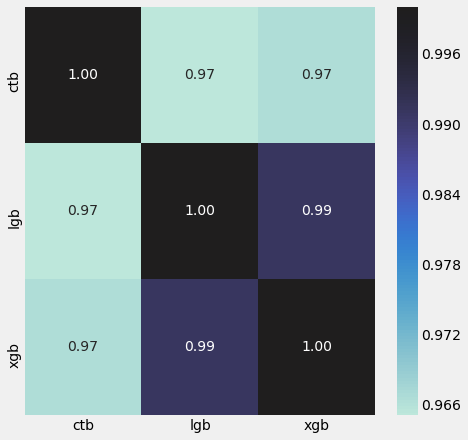

In [73]:
plt.rcParams['figure.figsize'] = 7, 7
preds = pd.DataFrame({'xgb': xgb_predictions, 'lgb':lgb_predictions,
              'ctb' : ctb_predictions})
sns.heatmap(preds.corr(), annot=True, fmt='.2f', center = True)

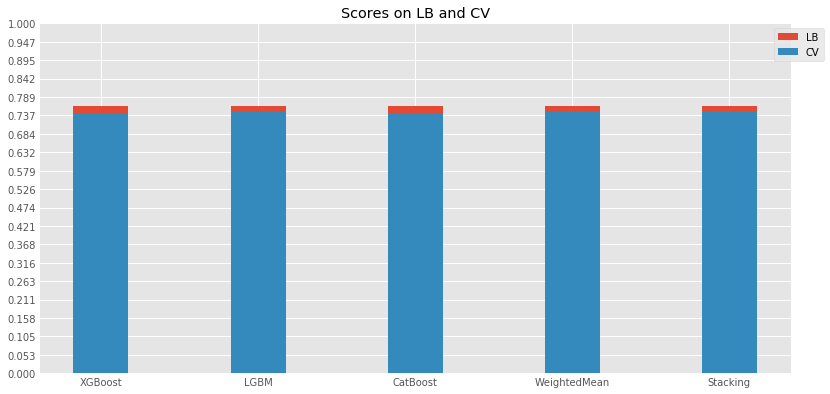

In [74]:
cv_scores = [0.7424, 0.74796, 0.74113 , 0.7431789, 0.750125  ]
lb_scores = [0.7641, 0.76364, 0.7646 , 0.7655, 0.7651 ]
estimators = ['XGBoost', 'LGBM', 'CatBoost', 'WeightedMean', 'Stacking']
stl.use('ggplot')
ind = np.arange(len(estimators))    # the x locations
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.rcParams['figure.figsize'] = 12, 6
p1 = plt.bar(ind, lb_scores, width), 
p2 = plt.bar(ind, cv_scores, width)

plt.title('Scores on LB and CV')
plt.xticks(ind, (estimators))
plt.yticks(np.linspace(0, 1, 20),  )
plt.legend((p1[0], p2[0]), ('LB', 'CV'), bbox_to_anchor=(1.05, 1))